In [1]:
!pip install ydata-profiling
# !pip install xgboost

DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/python_docx-1.1.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/Pattern-3.6.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [166]:
import re
import string
from typing import List, Dict

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from ydata_profiling import ProfileReport
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.linear_model import Ridge
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException, ElementClickInterceptedException
from bs4 import BeautifulSoup
# import chromedriver_autoinstaller
import time

## IMDBScraper Class

### Initialization
- **`__init__(self, user_agent)`**: Initializes the `IMDBScraper` class with a default user agent string. Sets up the Chrome WebDriver by calling the `_setup_chrome_driver` method.

### Chrome Driver Setup
- **`_setup_chrome_driver(self, user_agent)`**: Automatically installs the correct version of `chromedriver` that matches the installed Chrome version. Configures Chrome options to set the user-agent and initializes the Chrome WebDriver.

### Extract Movie Links
- **`extract_movie_links(self, genre, limit=100)`**: Extracts movie links from the specified IMDb genre page up to the given limit.
  - **Arguments**: 
    - `genre`: The genre to scrape.
    - `limit`: The maximum number of movie links to extract.
  - **Returns**: A list of dictionaries containing genre, movie ID, and movie URL.
  - **Logic**:
    - Navigates to the IMDb genre page.
    - Calculates the number of "Load More" button clicks needed to load enough movies.
    - Waits for the page to load and movie links to be present.
    - Extracts movie ID and URL from the page.
    - Clicks the "Load More" button if needed to load additional movie links.

### Wait for Page Load
- **`_wait_for_page_load(self, class_name)`**: Waits for the specified element class to be present on the page.
  - **Arguments**: 
    - `class_name`: The class name to wait for.
  - **Returns**: `True` if the element is present, `False` otherwise.

### Click Load More Button
- **`_click_load_more_button(self)`**: Clicks the "Load More" button to load additional movie links.
  - **Returns**: `True` if the button was clicked successfully, `False` otherwise.

### Close WebDriver
- **`close_driver(self)`**: Closes the WebDriver session.

### Save Movie Links to CSV
- **`save_movie_links_to_csv(self, movie_links, file_path)`**: Saves the extracted movie links to a CSV file.
  - **Arguments**:
    - `movie_links`: The list of movie links to save.
    - `file_path`: The path to save the CSV file.

## Main Script

### Genre Limits
- **`genre_limits` Dictionary**: Defines the genres as keys and the number of links to scrape for each genre as values.

### Scraper Initialization
- Initializes the `IMDBScraper` class.

### Scraping Loop
- Iterates over each key-value pair in the `genre_limits` dictionary.
- Scrapes the specified number of movie links for each genre using the `extract_movie_links` method.
- Extends the `all_movie_links` list with the scraped links for each genre.

### Save Data
- Saves the collected movie links to a single CSV file named `all_genres_movie_links.csv`.

### Close WebDriver
- Closes the WebDriver session.

### Completion Message
- Prints a message indicating that scraping is completed and the data is saved to the CSV file.


In [4]:
class IMDBScraper:
    def __init__(self,
                 user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"):
        """
        Initializing the IMDBScraper with the specified user agent and sets up the Chrome WebDriver.
        """
        self._setup_chrome_driver(user_agent)

    def _setup_chrome_driver(self, user_agent):
        """
        Setting up the Chrome WebDriver with the specified user agent.
        """
        # Automatically install the correct version of chromedriver that matches the installed Chrome version
        # TODO: uncomment if using windows device
        # chromedriver_autoinstaller.install()

        # Chrome options to set user-agent
        chrome_options = ChromeOptions()
        chrome_options.add_argument(f"user-agent={user_agent}")

        # Chrome service
        self.chrome_service = ChromeService()

        # Initializing Chrome WebDriver
        self.driver = webdriver.Chrome(service=self.chrome_service, options=chrome_options)

    def extract_movie_links(self, genre, limit=100):
        """
        Extracting movie links from the specified IMDb genre page up to the given limit.
        
        Args:
            genre (str): The genre to scrape.
            limit (int): The maximum number of movie links to extract.
            
        Returns:
            list: A list of dictionaries containing genre, movie ID, and movie URL.
        """
        base_url = 'https://www.imdb.com/search/title/?genres={}&explore=genres&title_type=feature'
        self.driver.get(base_url.format(genre))
        movie_links = []
        unique_movie_ids = set()

        # Calculating the number of clicks needed to load enough movies
        num_clicks = (limit - 1) // 50

        while len(movie_links) < limit:
            # Waiting for the page to load and movie links to be present
            if not self._wait_for_page_load('ipc-title-link-wrapper'):
                break

            soup = BeautifulSoup(self.driver.page_source, 'html.parser')
            link_elements = soup.find_all('a', class_='ipc-title-link-wrapper')

            # Extracting movie ID and URL
            for link_element in link_elements:
                href = link_element['href']
                full_url = f'https://www.imdb.com{href}'
                movie_id = href.split('/')[2].split('?')[0]

                if movie_id not in unique_movie_ids:
                    unique_movie_ids.add(movie_id)
                    movie_links.append({
                        'Genre': genre,
                        'Movie ID': movie_id,
                        'Movie URL': full_url
                    })
                    if len(movie_links) >= limit:
                        break

            # Clicking "Load More" button if needed
            if len(movie_links) < limit and num_clicks > 0:
                if not self._click_load_more_button():
                    break
                num_clicks -= 1

        return movie_links

    def _wait_for_page_load(self, class_name):
        """
        Waiting for the specified element class to be present on the page.
        
        Args:
            class_name (str): The class name to wait for.
            
        Returns:
            bool: True if the element is present, False otherwise.
        """
        try:
            WebDriverWait(self.driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, class_name)))
            time.sleep(2)
            return True
        except TimeoutException:
            print('Timeout waiting for page to load')
            return False
        except Exception as e:
            print(f'Error: {e}')
            return False

    def _click_load_more_button(self):
        """
        Clicking the "Load More" button to load additional movie links.
        
        Returns:
            bool: True if the button was clicked successfully, False otherwise.
        """
        try:
            load_more_button = WebDriverWait(self.driver, 10).until(EC.element_to_be_clickable(
                (By.XPATH, '//span[@class="ipc-see-more__text" and text()="50 more"]/ancestor::button')))
            self.driver.execute_script("arguments[0].click();", load_more_button)
            time.sleep(5)
            return True
        except (TimeoutException, NoSuchElementException):
            print("Load More button not found or clickable")
            return False
        except ElementClickInterceptedException:
            print("ElementClickInterceptedException: retrying")
            time.sleep(2)
            return self._click_load_more_button()

    def close_driver(self):
        """
        Closes the WebDriver session.
        """
        self.driver.quit()

    def save_movie_links_to_csv(self, movie_links, file_path):
        """
        Saving the extracted movie links to a CSV file.
        
        Args:
            movie_links (list): The list of movie links to save.
            file_path (str): The path to save the CSV file.
        """
        df = pd.DataFrame(movie_links)
        df.to_csv(file_path, index=False)


# Defining the limit for each genre
genre_limits = {
    'drama': 100,
    'horror': 50,
    'mystery': 70,
    'thriller': 80,
    'sci-fi': 60,
    'war': 40,
    'fantasy': 90,
    'western': 30,
    'romance': 100,
    'documentary': 50,
    'comedy': 120,
    'action': 110,
    'animation': 80
}


# TODO: uncomment to scrape data
# # Initializing the scraper
# scraper = IMDBScraper()
# 
# all_movie_links = []
# 
# # Scraping movie links for each genre
# for genre, limit in genre_limits.items():
#     print(f"Scraping genre: {genre} with limit: {limit}")
#     genre_movie_links = scraper.extract_movie_links(genre, limit=limit)
#     all_movie_links.extend(genre_movie_links)
#     print(f"Scraped {len(genre_movie_links)} movies for genre: {genre}")
# 
# # Saving all movie links to a single CSV file
# all_movies_df = pd.DataFrame(all_movie_links)
# all_movies_df.to_csv('all_genres_movie_links.csv', index=False)
# 
# # Closing the WebDriver
# scraper.close_driver()

### IMDbMovieScraper Class Initialization:

- The `IMDbMovieScraper` class is initialized with a DataFrame and the column name containing movie URLs.
- ChromeDriver is automatically installed and configured with appropriate options.
- A Chrome WebDriver instance is created.

### Text Extraction with Pseudo-Elements:

- The `get_text_with_pseudo` method is defined to extract text content, including pseudo-elements, using JavaScript execution.

### Movie Data Scraping:

- The `scrape_movie_data` method is defined to scrape detailed movie data from a given IMDb movie URL. This method uses BeautifulSoup to parse the page and extract various movie details.

### Individual Data Extraction Methods:

- Several helper methods (e.g., `extract_movie_id`, `extract_title`, `extract_imdb_rating`, etc.) are defined to extract specific pieces of information from the BeautifulSoup object.

### Scraping All Movies:

- The `scrape_all_movies` method iterates over all URLs in the specified column of the DataFrame and scrapes data for each movie.

### DataFrame Creation:

- The `get_movie_data_dataframe` method returns the scraped movie data as a pandas DataFrame.

### WebDriver Closure:

- The `close_driver` method closes the WebDriver instance.


In [5]:
class IMDbMovieScraper:
    def __init__(self, dataframe, url_column):
        """
        Initializing the IMDbMovieScraper with a DataFrame and the column name containing movie URLs.
        """
        self.dataframe = dataframe
        self.url_column = url_column
        self.movie_data_list = []

        # TODO: uncomment if using windows device
        # Automatically install the correct version of ChromeDriver
        # chromedriver_autoinstaller.install()

        # Chrome options to set user-agent
        chrome_options = ChromeOptions()
        chrome_options.add_argument(
            "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        )

        # Chrome service
        chrome_service = ChromeService()

        # Initialize Chrome WebDriver
        self.driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

    def get_text_with_pseudo(self, element):
        """
        Extracting text including pseudo-elements.
        """
        script = """
        var element = arguments[0];
        var before = window.getComputedStyle(element, '::before').getPropertyValue('content');
        var text = element.textContent;
        return before.replace(/"/g, '') + text;
        """
        return self.driver.execute_script(script, element).strip()

    def scrape_movie_data(self, movie_url):
        """
        Scraping movie data from a given IMDb movie URL.
        """
        self.driver.get(movie_url)
        try:
            WebDriverWait(self.driver, 20).until(EC.title_contains("IMDb"))
        except TimeoutException:
            print(f"Timeout waiting for {movie_url} to load IMDb page title")
            return None

        soup = BeautifulSoup(self.driver.page_source, 'html.parser')

        movie_details = {
            "Movie ID": self.extract_movie_id(movie_url),
            "Title": self.extract_title(soup),
            "IMDB Rating": self.extract_imdb_rating(soup),
            "Directors": self.extract_credits(soup, 0),
            "Writers": self.extract_credits(soup, 1),
            "Stars": self.extract_credits(soup, 2),
            "Storyline": self.extract_storyline(soup),
            "Release Date": self.extract_release_date(soup),
            "Origin Countries": self.extract_origin_countries(soup),
            "Languages": self.extract_languages(soup),
            "Budget": self.extract_budget(soup),
            "Gross Worldwide": self.extract_gross_worldwide(soup),
            "Runtime": self.extract_runtime(soup),
            "Genres": self.extract_genres(soup)
        }

        return movie_details

    def extract_movie_id(self, movie_url):
        """
        Extracting the movie ID from the IMDb URL.
        """
        return movie_url.split('/')[4]

    def extract_title(self, soup):
        """
        Extracting the movie title from the BeautifulSoup object.
        """
        return soup.find('span', {'data-testid': 'hero__primary-text'}).text if soup.find('span', {
            'data-testid': 'hero__primary-text'}) else 'N/A'

    def extract_imdb_rating(self, soup):
        """
        Extracting the IMDb rating from the BeautifulSoup object.
        """
        return soup.find('span', class_='sc-bde20123-1').text if soup.find('span', class_='sc-bde20123-1') else 'N/A'

    def extract_credits(self, soup, credit_index):
        """
        Extracting the credits (directors, writers, stars) from the BeautifulSoup object.
        """
        credits_section = soup.find_all('li', {'data-testid': 'title-pc-principal-credit'})
        if len(credits_section) > credit_index:
            credits = []
            for elem in credits_section[credit_index].find_all('a'):
                try:
                    element = self.driver.find_element(By.XPATH, f'//a[@href="{elem["href"]}"]')
                    credits.append(self.get_text_with_pseudo(element))
                except Exception:
                    credits.append('N/A')
            return ", ".join(credits)
        return 'N/A'

    def extract_storyline(self, soup):
        """
        Extracting the movie storyline from the BeautifulSoup object.
        """
        return soup.find('span', {'data-testid': 'plot-xl'}).text if soup.find('span',
                                                                               {'data-testid': 'plot-xl'}) else 'N/A'

    def extract_release_date(self, soup):
        """
        Extracting the release date from the BeautifulSoup object.
        """
        release_date_elem = soup.find('li', {'data-testid': 'title-details-releasedate'}).find('a') if soup.find('li', {
            'data-testid': 'title-details-releasedate'}) else None
        return release_date_elem.text.strip() if release_date_elem else 'N/A'

    def extract_origin_countries(self, soup):
        """
        Extracting the origin countries from the BeautifulSoup object.
        """
        return ", ".join(
            [a.text for a in soup.find('li', {'data-testid': 'title-details-origin'}).find_all('a')]) if soup.find('li',
                                                                                                                   {
                                                                                                                       'data-testid': 'title-details-origin'}) else 'N/A'

    def extract_languages(self, soup):
        """
        Extracting the languages from the BeautifulSoup object.
        """
        return ", ".join(
            [a.text for a in soup.find('li', {'data-testid': 'title-details-languages'}).find_all('a')]) if soup.find(
            'li', {'data-testid': 'title-details-languages'}) else 'N/A'

    def extract_budget(self, soup):
        """
        Extracting the budget from the BeautifulSoup object.
        """
        return soup.find('li', {'data-testid': 'title-boxoffice-budget'}).find('span',
                                                                               class_='ipc-metadata-list-item__list-content-item').text if soup.find(
            'li', {'data-testid': 'title-boxoffice-budget'}) else 'N/A'

    def extract_gross_worldwide(self, soup):
        """
        Extracting the gross worldwide revenue from the BeautifulSoup object.
        """
        return soup.find('li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'}).find('span',
                                                                                                 class_='ipc-metadata-list-item__list-content-item').text if soup.find(
            'li', {'data-testid': 'title-boxoffice-cumulativeworldwidegross'}) else 'N/A'

    def extract_runtime(self, soup):
        """
        Extracting the runtime from the BeautifulSoup object.
        """
        return soup.find('li', {'data-testid': 'title-techspec_runtime'}).find('div').text.strip() if soup.find('li', {
            'data-testid': 'title-techspec_runtime'}) else 'N/A'

    def extract_genres(self, soup):
        """
        Extracting the genres from the BeautifulSoup object.
        """
        genres = []
        genres_container = soup.find('div', {'data-testid': 'genres'})
        if genres_container:
            genre_links = genres_container.find_all('a')
            genres = [link.text.strip() for link in genre_links]
        return ", ".join(genres) if genres else 'N/A'

    def scrape_all_movies(self):
        """
        Scraping data for all movies listed in the DataFrame.
        """
        if self.url_column in self.dataframe.columns:
            for url in self.dataframe[self.url_column]:
                movie_data = self.scrape_movie_data(url)
                if movie_data:
                    self.movie_data_list.append(movie_data)
        else:
            print(f"Column '{self.url_column}' not found in DataFrame")

    def get_movie_data_dataframe(self):
        """
        Return the scraped movie data as a DataFrame.
        """
        return pd.DataFrame(self.movie_data_list)

    def close_driver(self):
        """
        Closing the WebDriver.
        """
        self.driver.quit()

# TODO: uncomment to scrape data

# # This is the dataframe which was saved after the execution completion of the genre link scerping class
# df_all_movies = all_movies_df
# 
# # Initializing the scraper
# scraper = IMDbMovieScraper(dataframe=df_all_movies, url_column='Movie URL')
# 
# # Scraping all movies
# scraper.scrape_all_movies()
# 
# # Getting the scraped data as a DataFrame
# all_movie_df = scraper.get_movie_data_dataframe()
# 
# # Closing the WebDriver
# scraper.close_driver()


In [6]:
"""
This Clas handles the text in the dataset
- it's used to a manipulate textual data
"""


class TextWrangler:
    def __init__(self):
        self.count = CountVectorizer()
        self.tf_idf_ = TfidfVectorizer()
        self.spacy_en = spacy.load('en_core_web_sm')
        # Download stopwords if not already downloaded
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            import nltk
            nltk.download('stopwords')
            nltk.download('punkt')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_digit(text: str) -> str:
        """
        This method removes digit from a text
        """
        return re.sub(r'\d+', '', text)

    @staticmethod
    def remove_punctuations(text: str) -> str:
        """
        This method removes punctuation from a text
        """
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def clean_text(text: str) -> str:
        """
        Clean the text and remove punctuations.
        """
        text = re.sub('<.*?>', '', text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        return text.lower()

    @staticmethod
    def word_lengthening(text: str) -> str:
        """
        Fix a word by reducing any character repeated three or more times
        to just two instances of that character.
        """
        return re.sub(r'(.)\1{2,}', r'\1\1', text.strip())

    @staticmethod
    def tokenize(text: str) -> List[str]:
        """
        Tokenize the given text into words.
        """
        return word_tokenize(text)

    def remove_stopwords(self, text: str) -> str:
        """
        Remove stop words from a given text.
        """
        filtered_text = [word for word in self.tokenize(text) if word.lower() not in self.stop_words]
        return ' '.join(filtered_text)

    def lemmatizer(self, text: str) -> str:
        """
        This method lemmatize a text by using the spaCy libary
        """
        text = self.spacy_en(text)

        # get the lemmatized token from text
        lemmatized_tokens = [token.lemma_ for token in text]

        # use lemmatized token to form a sentence
        return ' '.join(lemmatized_tokens)

    def init_bag_of_words(self, end_range: int):
        """
        This method initialize Bag of Words with n_gram end range which can be 1, 2 or 3
        """
        self.count = CountVectorizer(ngram_range=(1, end_range))
        return self.count

    def bag_of_words(self, text: List[str]):
        """
        Compute the Bag of Words matrix for the given list of texts.
        """
        return self.count.fit_transform(text)

    def init_tf_idf(self, end_range: int):
        """
        This method initialize TF-IDF with n_gram end range which can be 1, 2 or 3
        """
        self.tf_idf_ = TfidfVectorizer(ngram_range=(1, end_range))
        return self.tf_idf_

    def tf_idf(self, text: List[str]):
        """
        Compute the TF-IDF matrix for the given list of texts.
        """
        return self.tf_idf_.fit_transform(text)

    @staticmethod
    def plot_word_cloud(data, title):
        """
        Generate a graphical representation of the words in the text
        """
        wordcloud = WordCloud(width=900, height=600, max_words=100, background_color='white').generate(data)

        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return


text_wrangler = TextWrangler()

In [7]:
"""
TextSentimentAnalysis Class provides the sentiment for the input text in its raw form
"""


class TextSentimentAnalysis:
    def __init__(self) -> None:
        """
        Initialize vader sentiment analyzer
        """
        self.sid = SentimentIntensityAnalyzer()

    def get_sentiment_via_vader(self, text: str) -> float:
        """
        return the compound score
        """
        # Using compound score as a single sentiment score
        return self.sid.polarity_scores(text)['compound']


text_sentiment_analysis = TextSentimentAnalysis()

In [8]:
"""
This class handles currency conversion on revenue and budget columns
"""


class CurrencyConverter:
    def __init__(self):
        self.exchange_rates: Dict[str, float] = {
            '$': 1.0,  # USD to USD (base currency)
            '€': 1.13,  # EUR to USD
            'FRF\xa0': 0.18,  # FRF to USD (Note: FRF is the French Franc, not in use anymore)
            '£': 1.41  # GBP to USD
        }

    # This function is to convert all the currencies to USD for gross_worldwide feature
    def convert_revenue_to_usd(self, amount):
        if isinstance(amount, str):
            if amount.startswith('$'):
                # Remove currency symbol
                amount = amount[1:]
                # Remove commas  
                amount = amount.replace(',', '')
                # Converting to float 
                return float(amount)
            elif amount.startswith('€'):
                amount = amount[1:]
                amount = amount.replace(',', '')
                amount = float(amount)
                return amount * self.exchange_rates['€']
            elif amount.startswith('FRF\xa0'):
                amount = amount[4:]
                amount = amount.replace(',', '')
                amount = float(amount)
                return amount * self.exchange_rates['FRF\xa0']
            elif amount.startswith('£'):
                amount = amount[1:]
                amount = amount.replace(',', '')
                amount = float(amount)
                return amount * self.exchange_rates['£']
                # Return None if the currency is not supported
            else:
                return None
                # Return None if the currency is not string
        else:
            return None

    # Function to convert to USD
    def convert_budget_to_usd(self, amount):
        if isinstance(amount, str):
            # Remove any non-numeric characters (except currency symbols, periods, and commas)
            amount_cleaned = re.sub(r'[^\d\.,€$£FRF\xa0]', '', amount)

            if amount_cleaned.startswith('$'):
                return float(amount_cleaned[1:].replace(',', ''))  # Remove '$' and commas, convert to float
            elif amount_cleaned.startswith('€'):
                return float(amount_cleaned[1:].replace(',', '')) * self.exchange_rates['€']
            elif amount_cleaned.startswith('FRF\xa0'):
                return float(amount_cleaned[4:].replace(',', '')) * self.exchange_rates['FRF\xa0']
            elif amount_cleaned.startswith('£'):
                return float(amount_cleaned[1:].replace(',', '')) * self.exchange_rates['£']
            else:
                return None  # Return None for unsupported currencies
        else:
            return None  # Return None for non-string types


currency_converter = CurrencyConverter()

In [9]:
class Utility:
    def __init__(self):
        pass

    @staticmethod
    def generate_correlation_heatmap(df, columns, title):
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[columns].dropna().corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def average_percentage_missing_values(df):
        return df.isna().mean().round(2) * 100

    @staticmethod
    def missing_value_count(df) -> int:
        return df.isna().sum()

    @staticmethod
    def transform_cells(text: str) -> List[str]:
        # Step 1: Define patterns to remove
        patterns = [
            r'none(?:Directors|Writers|Stars|Writer)',  # Matches noneDirectors, noneWriters, noneStars, noneWriter
            r'\u200b',  # Matches zero-width space
        ]

        # Step 2: Replace defined patterns with an empty string
        for pattern in patterns:
            text = re.sub(pattern, '', text)

        # Step 3: Split the string into a list based on ","
        return re.split(r',\s*', text.strip(', '))

    def categorize_column(self, df, column: str) -> List[str]:
        categories = []  # Empty list to store transformed records

        for data in df[column]:
            # Check if record has a null value
            if pd.isnull(data):
                # Fill with 'not reported' if null
                categories.append('not reported')
            else:
                if len(self.transform_cells(data)) < 3:
                    categories.append('small')
                else:
                    categories.append('large')

        return categories

    @staticmethod
    def group_column_with_check(df, column_name: str, check: str) -> List[str]:
        group: List[str] = []

        for data in df[column_name]:
            if pd.isnull(data):
                group.append('not reported')
            elif pd.isnull(data) == False and check in data:
                group.append('yes')
            else:
                group.append('no')

        return group


utility = Utility()

In [10]:
class Outlier:
    def __init__(self):
        pass

    @staticmethod
    def iqr_range(df, df2, feature):
        # Calculating IQR for current feature
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1

        # outlier boundaries for current feature
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr

        # finding the count of outliers for each feature
        return ((df2[feature] < lower_whisker) | (df2[feature] > upper_whisker)).sum()

    @staticmethod
    def trimming(df, features):
        indices_to_keep = set(df.index)

        for feature in features:
            # Calculating IQR for current feature
            q1 = df[feature].quantile(0.25)
            q3 = df[feature].quantile(0.75)
            iqr = q3 - q1

            # Outlier boundaries for current feature
            lower_whisker = q1 - 1.5 * iqr
            upper_whisker = q3 + 1.5 * iqr

            # Finding indices of the rows within the whiskers
            current_indices = df[(df[feature] > lower_whisker) | (df[feature] < upper_whisker)].index
            indices_to_keep &= set(current_indices)

        return df.loc[list(indices_to_keep)]

    @staticmethod
    def log_transformation(df, feature):
        return df[feature].map(lambda data: np.log(data) if data > 0 else 0)

    @staticmethod
    def floor_cap(df, df2, feature):
        floor = df[feature].quantile(0.01)
        cap = df[feature].quantile(0.99)

        df2[feature] = np.where(df2[feature] < floor, floor, df2[feature])
        df2[feature] = np.where(df2[feature] > cap, cap, df2[feature])

        return floor, cap

    @staticmethod
    def skewness(df, feature):
        return df[feature].skew().round(2), df[feature].hist(bins=25)


outlier = Outlier()

#### Project Setup and Data Collection: ✅

1) Set up your Jupyter notebook ✅
2) Scrape or pull data from online resources ✅
3) Load the data into your notebook ✅ <br /><br />


In [11]:
# Load the dataset into your notebook 

df = pd.read_csv(
    'dataset.csv',
    index_col=0,
)

In [12]:
df.columns

Index(['Movie ID', 'Title', 'IMDB Rating', 'Directors', 'Writers', 'Stars',
       'Storyline', 'Origin Countries', 'Languages', 'Budget',
       'Gross Worldwide', 'Runtime', 'Genres'],
      dtype='object')

In [13]:
df.rename(columns={
    'Movie ID': 'id',
    'Title': 'title',
    'IMDB Rating': 'rating',
    'Directors': 'directors',
    'Writers': 'writers',
    'Stars': 'stars',
    'Storyline': 'storyline',
    'Origin Countries': 'origin_countries',
    'Languages': 'languages',
    'Budget': 'budget',
    'Gross Worldwide': 'revenue',
    'Runtime': 'runtime',
    'Genres': 'genres'
}, inplace=True)

In [14]:
df.head()

,id,title,rating,directors,writers,stars,storyline,origin_countries,languages,budget,revenue,runtime,genres
0,tt0060437,Funeral in Berlin,6.8,​Guy Hamilton,"​Len Deighton, ​Evan Jones",", ​Michael Caine, ​Oscar Homolka, ​Paul Hubsch...",Sent to East Berlin to retrieve a Communist de...,United Kingdom,"English, German",NaN,$183,1 hour 42 minutes,Thriller
1,tt0098300,Shag,NaN,​Zelda Barron,", ​Lanier Laney, ​Terry Sweeney, ​Robin Swicord,",", ​Phoebe Cates, ​Bridget Fonda, ​Scott Coffey,",Summer of 1963. Carson is getting married to h...,"United States, United Kingdom",English,"$5,000,000 (estimated)","$6,957,975",1 hour 38 minutes,"Comedy, Drama, Romance"
2,tt1853739,You're Next,6.6,​Adam Wingard,​Simon Barrett,", ​Sharni Vinson, ​Joe Swanberg, ​AJ Bowen,",When the Davison family comes under attack dur...,"United States, United Kingdom",English,"$1,000,000 (estimated)","$26,895,481",1 hour 35 minutes,"Drama, Horror, Thriller"
3,tt22036900,Covid Karma,NaN,​Biju Viswanath,"noneStars, ​Rodney Norman, ​Christine Ohlman, ...",​Biju Viswanath,An Indian film maker is stuck in USA for five ...,United States,English,NaN,NaN,1 hour 1 minute,"Biography, Comedy"
4,tt0419434,American Hardcore,NaN,​Paul Rachman,"noneWriter, ​Steven Blush, noneWriter",", ​Greg Ginn, ​Ian MacKaye, ​James Drescher,",The History of American Punk Rock 1980-1986,United States,English,NaN,"$376,057",1 hour 40 minutes,"Documentary, History, Music"


In [15]:
def convert_runtime_to_minutes(runtime):
    if 'hour' in runtime and 'minute' in runtime:
        try:
            hours, minutes = runtime.split(' hour ')
            minutes = minutes.replace(' minutes', '')
            total_minutes = int(hours) * 60 + int(minutes)
        except ValueError:
            total_minutes = 0
    elif 'hour' in runtime:
        try:
            hours = runtime.replace(' hours', '').replace(' hour', '')
            total_minutes = int(hours) * 60
        except ValueError:
            total_minutes = 0
    elif 'minute' in runtime:
        try:
            minutes = runtime.replace(' minutes', '')
            total_minutes = int(minutes)
        except ValueError:
            total_minutes = 0
    else:
        total_minutes = 0  # Handle unexpected cases gracefully

    return total_minutes

In [16]:
df['revenue_in_usd'] = df['revenue'].apply(currency_converter.convert_revenue_to_usd)

df['revenue_in_usd'].head()

0         183.0
1     6957975.0
2    26895481.0
3           NaN
4      376057.0
Name: revenue_in_usd, dtype: float64

In [17]:
df['budget_in_usd'] = df['budget'].apply(currency_converter.convert_budget_to_usd)

df['budget_in_usd'].head()

0          NaN
1    5000000.0
2    1000000.0
3          NaN
4          NaN
Name: budget_in_usd, dtype: float64

In [18]:
df['runtime'].fillna('', inplace=True)

# Apply the function to convert runtime to minutes
df['runtime_in_minutes'] = df['runtime'].apply(convert_runtime_to_minutes)

df['runtime_in_minutes'].head()

0    102
1     98
2     95
3      0
4    100
Name: runtime_in_minutes, dtype: int64

2. Exploratory Data Analysis (EDA):
    - 2.1 Initial data inspection (shape, info, describe)  ✅
    - 2.2 Generate and save pandas profiling report  ✅
    - 2.3 Visualize data distributions ('IMDB Rating', 'Budget', 'Gross Worldwide', 'Runtime')  ✅
    - 2.4 Explore relationships between 'Gross Worldwide' and other variables  ✅
    - 2.5 Analyze categorical data ('Directors', 'Writers', 'Stars', 'Origin Countries', 'Languages', 'Genres')  ✅
    - 2.6 Identify potential issues (missing values, duplicates)<br /><br />


#### 2.1 Initial data inspection (shape, info, describe)

In [19]:
df.shape

(46646, 16)

we've 13 columns (features) and 46,646 rows in this dataset

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46646 entries, 0 to 46645
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  46646 non-null  object 
 1   title               46573 non-null  object 
 2   rating              24971 non-null  float64
 3   directors           43308 non-null  object 
 4   writers             43308 non-null  object 
 5   stars               43308 non-null  object 
 6   storyline           42363 non-null  object 
 7   origin_countries    44661 non-null  object 
 8   languages           43435 non-null  object 
 9   budget              14748 non-null  object 
 10  revenue             17622 non-null  object 
 11  runtime             46646 non-null  object 
 12  genres              46572 non-null  object 
 13  revenue_in_usd      17593 non-null  float64
 14  budget_in_usd       13472 non-null  float64
 15  runtime_in_minutes  46646 non-null  int64  
dtypes: float6

In [21]:
df.describe()

,rating,revenue_in_usd,budget_in_usd,runtime_in_minutes
count,24971.000000,1.759300e+04,1.347200e+04,46646.000000
mean,6.135405,3.974123e+07,1.944457e+07,71.450542
std,1.223421,1.231753e+08,3.911374e+07,417.610945
min,1.000000,3.000000e+00,1.000000e+00,0.000000
25%,5.400000,1.740360e+05,1.000000e+06,0.000000
50%,6.300000,2.443487e+06,5.500000e+06,87.000000
75%,7.000000,2.222751e+07,2.000000e+07,98.000000
max,10.000000,2.923706e+09,2.000000e+09,59460.000000


In [22]:
# 2.2 Generate and save pandas profiling report
profile = ProfileReport(df, title="Movie Report")
profile.to_file('movie_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
df.head()

,id,title,rating,directors,writers,stars,storyline,origin_countries,languages,budget,revenue,runtime,genres,revenue_in_usd,budget_in_usd,runtime_in_minutes
0,tt0060437,Funeral in Berlin,6.8,​Guy Hamilton,"​Len Deighton, ​Evan Jones",", ​Michael Caine, ​Oscar Homolka, ​Paul Hubsch...",Sent to East Berlin to retrieve a Communist de...,United Kingdom,"English, German",NaN,$183,1 hour 42 minutes,Thriller,183.0,NaN,102
1,tt0098300,Shag,NaN,​Zelda Barron,", ​Lanier Laney, ​Terry Sweeney, ​Robin Swicord,",", ​Phoebe Cates, ​Bridget Fonda, ​Scott Coffey,",Summer of 1963. Carson is getting married to h...,"United States, United Kingdom",English,"$5,000,000 (estimated)","$6,957,975",1 hour 38 minutes,"Comedy, Drama, Romance",6957975.0,5000000.0,98
2,tt1853739,You're Next,6.6,​Adam Wingard,​Simon Barrett,", ​Sharni Vinson, ​Joe Swanberg, ​AJ Bowen,",When the Davison family comes under attack dur...,"United States, United Kingdom",English,"$1,000,000 (estimated)","$26,895,481",1 hour 35 minutes,"Drama, Horror, Thriller",26895481.0,1000000.0,95
3,tt22036900,Covid Karma,NaN,​Biju Viswanath,"noneStars, ​Rodney Norman, ​Christine Ohlman, ...",​Biju Viswanath,An Indian film maker is stuck in USA for five ...,United States,English,NaN,NaN,1 hour 1 minute,"Biography, Comedy",NaN,NaN,0
4,tt0419434,American Hardcore,NaN,​Paul Rachman,"noneWriter, ​Steven Blush, noneWriter",", ​Greg Ginn, ​Ian MacKaye, ​James Drescher,",The History of American Punk Rock 1980-1986,United States,English,NaN,"$376,057",1 hour 40 minutes,"Documentary, History, Music",376057.0,NaN,100


#### 2.3 Visualize distributions of numerical columns

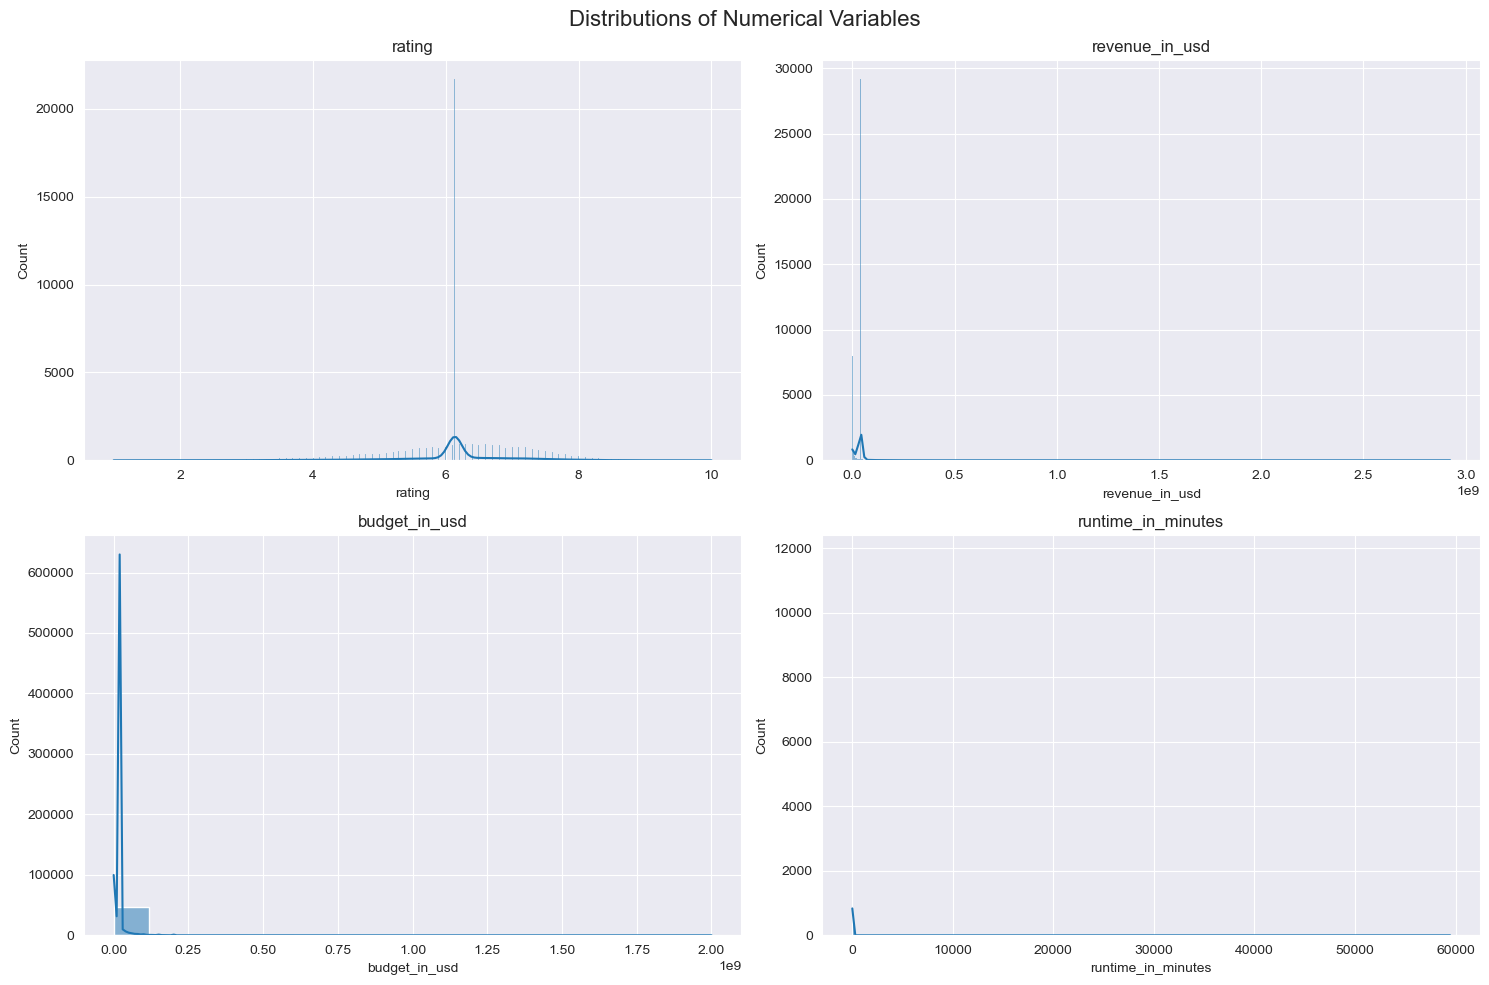

In [81]:
# select all numerical columns
numerical_cols = ['rating', 'revenue_in_usd', 'budget_in_usd', 'runtime_in_minutes']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distributions of Numerical Variables', fontsize=16)

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(col)

plt.tight_layout()
plt.show()

In [25]:
for column in numerical_cols:
    correlation = df[[column, 'revenue_in_usd']].dropna().corr().iloc[0, 1]
    print(f"Correlation between '{column.replace('_', ' ')}' and 'revenue': {correlation:.2f}")

Correlation between 'rating' and 'revenue': 0.17
Correlation between 'revenue in usd' and 'revenue': 1.00
Correlation between 'budget in usd' and 'revenue': 0.72
Correlation between 'runtime in minutes' and 'revenue': -0.13


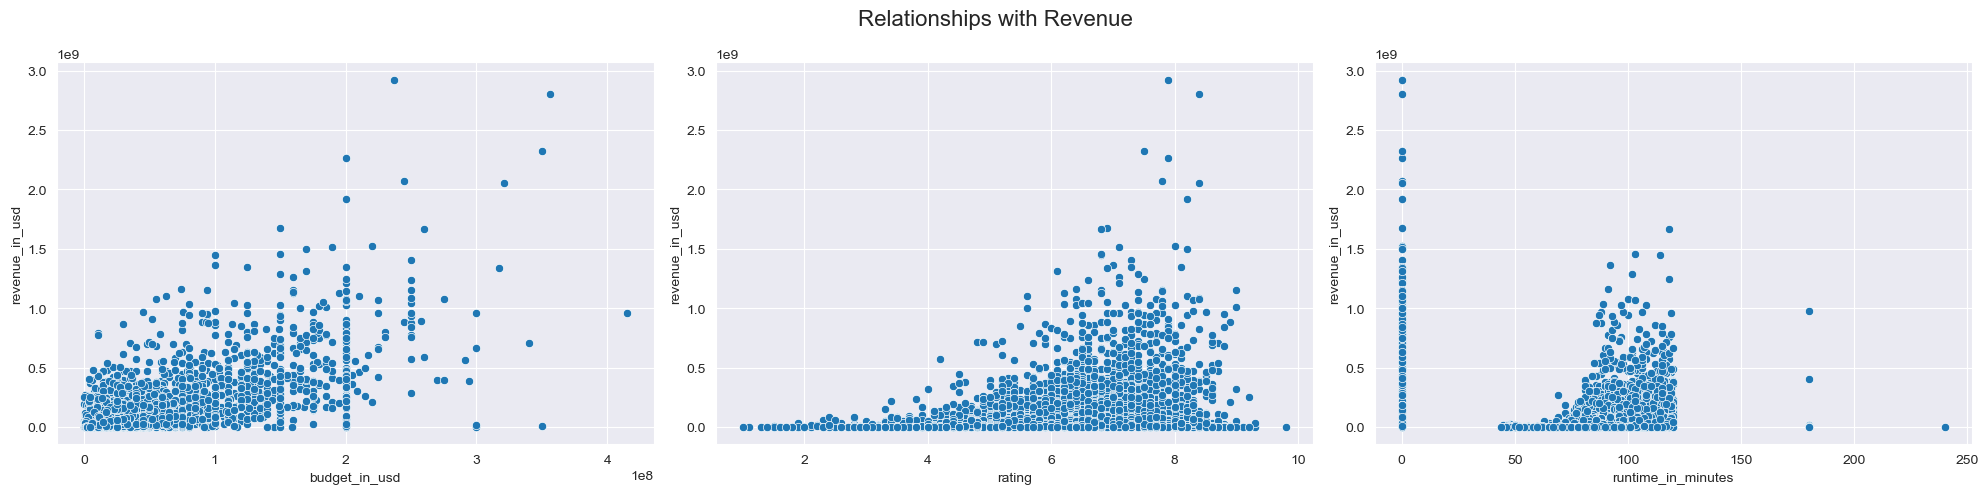

In [26]:
# 2.4 Explore relationships between 'revenue_in_usd' and other numerical variables
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Relationships with Revenue', fontsize=16)

sns.scatterplot(data=df, x='budget_in_usd', y='revenue_in_usd', ax=axes[0])
sns.scatterplot(data=df, x='rating', y='revenue_in_usd', ax=axes[1])
sns.scatterplot(data=df, x='runtime_in_minutes', y='revenue_in_usd', ax=axes[2])

plt.tight_layout()
plt.show()

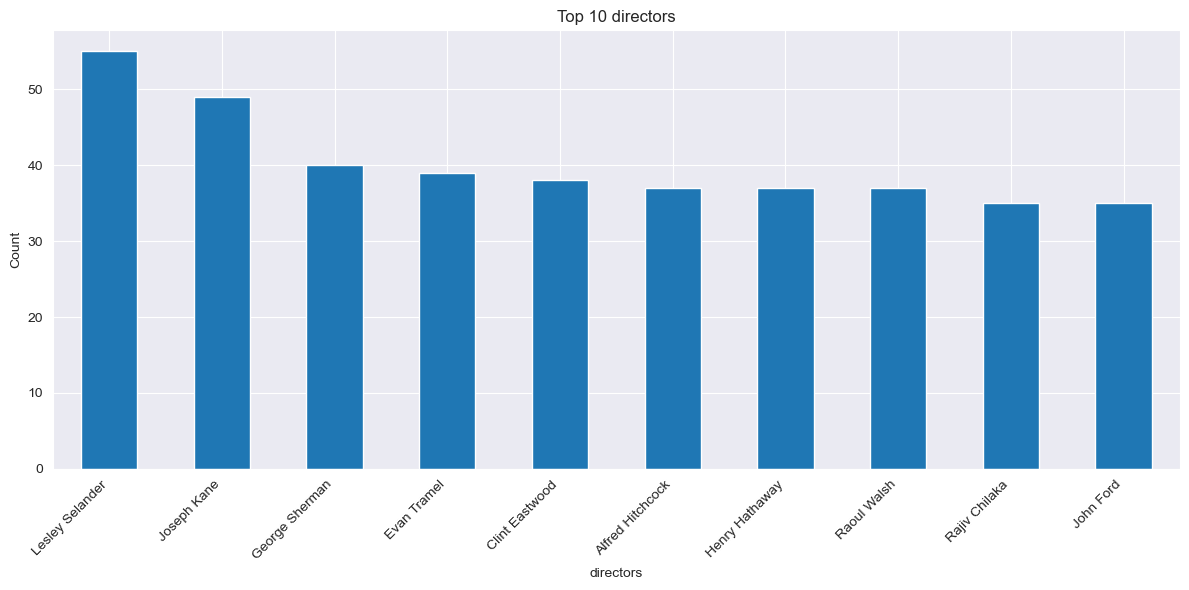

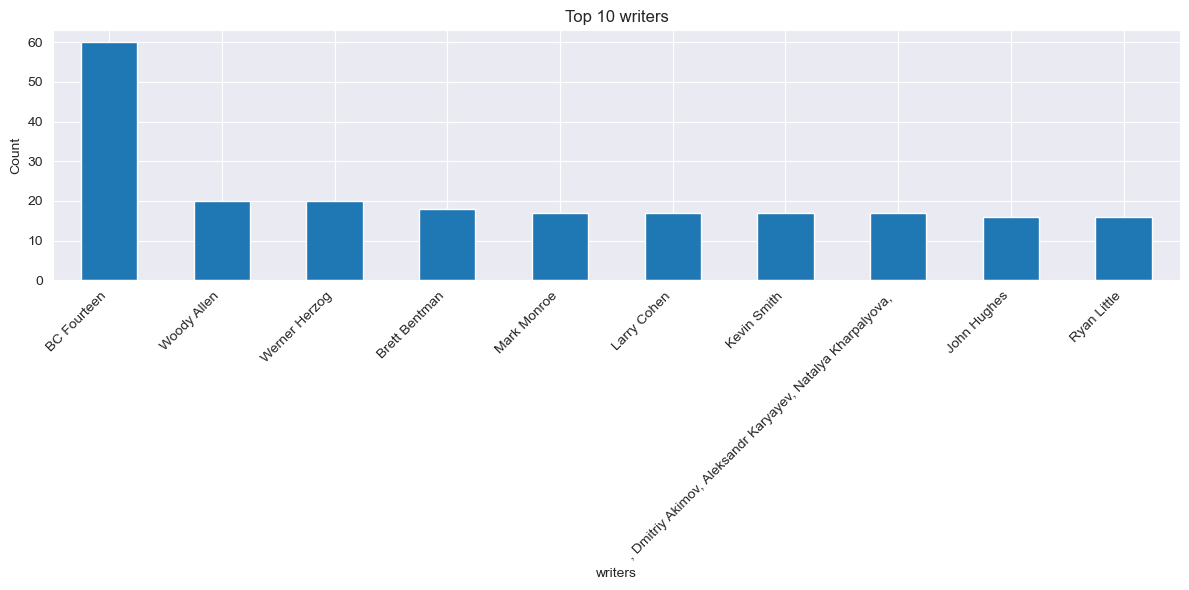

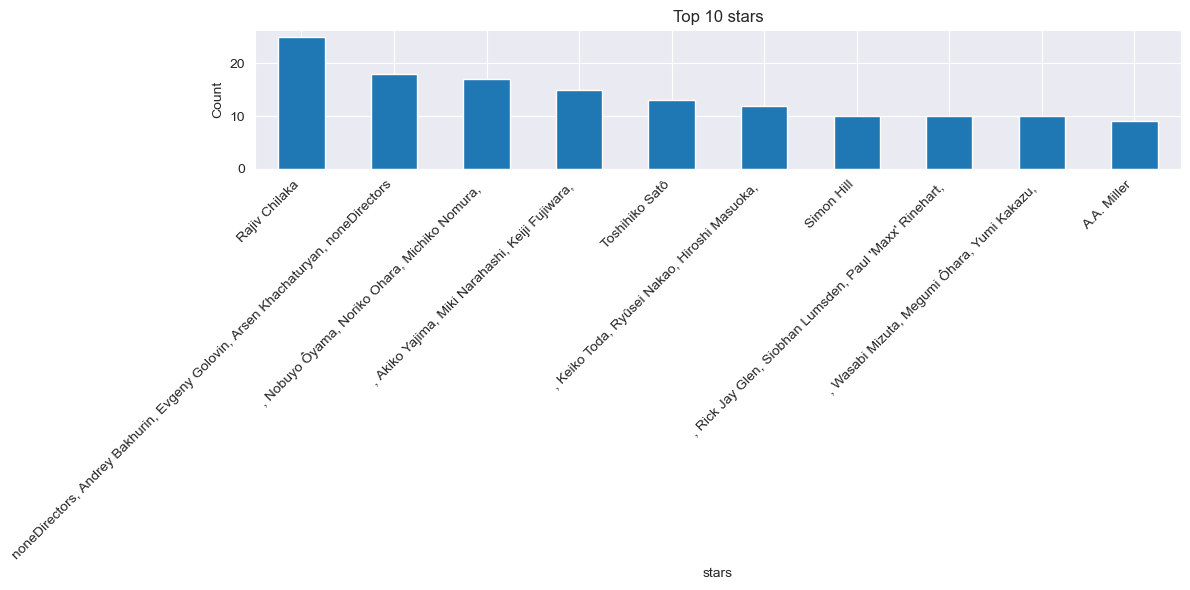

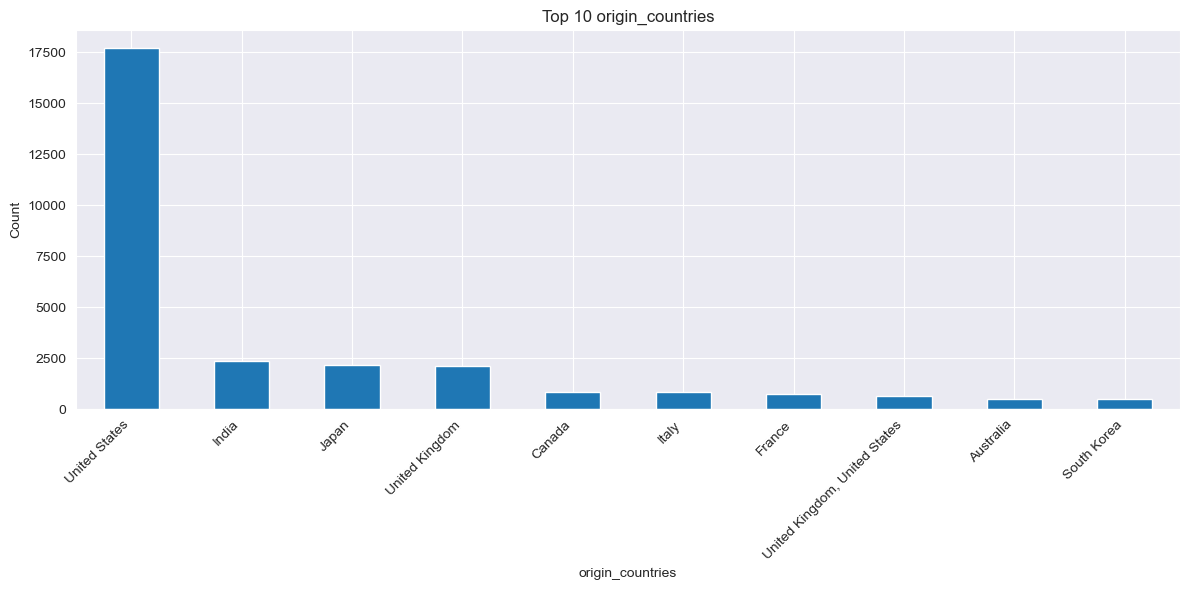

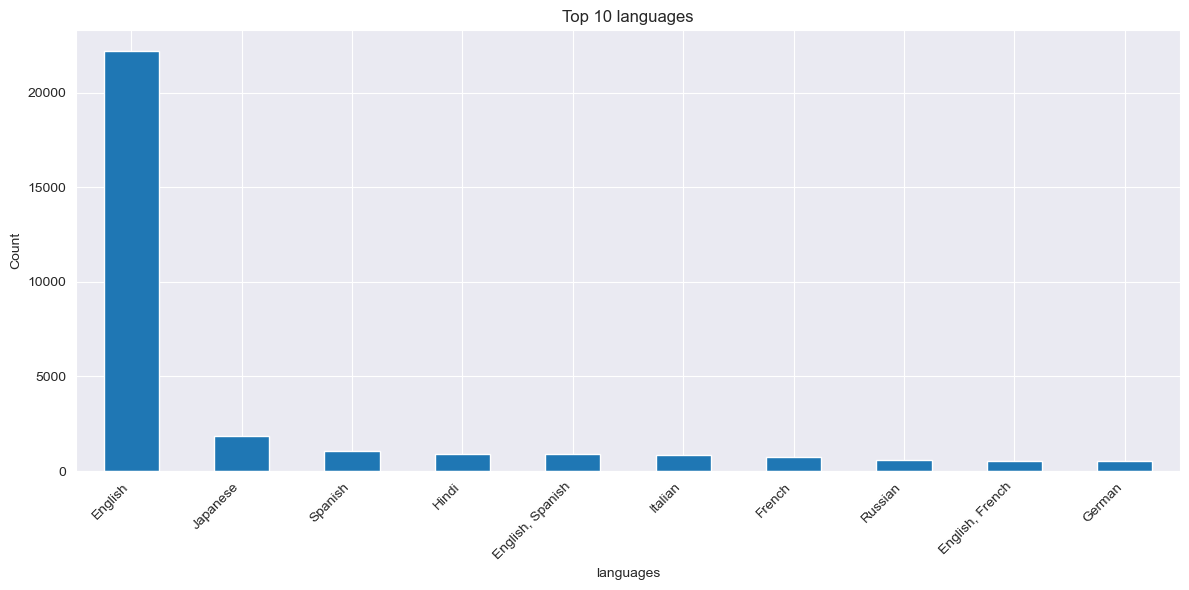

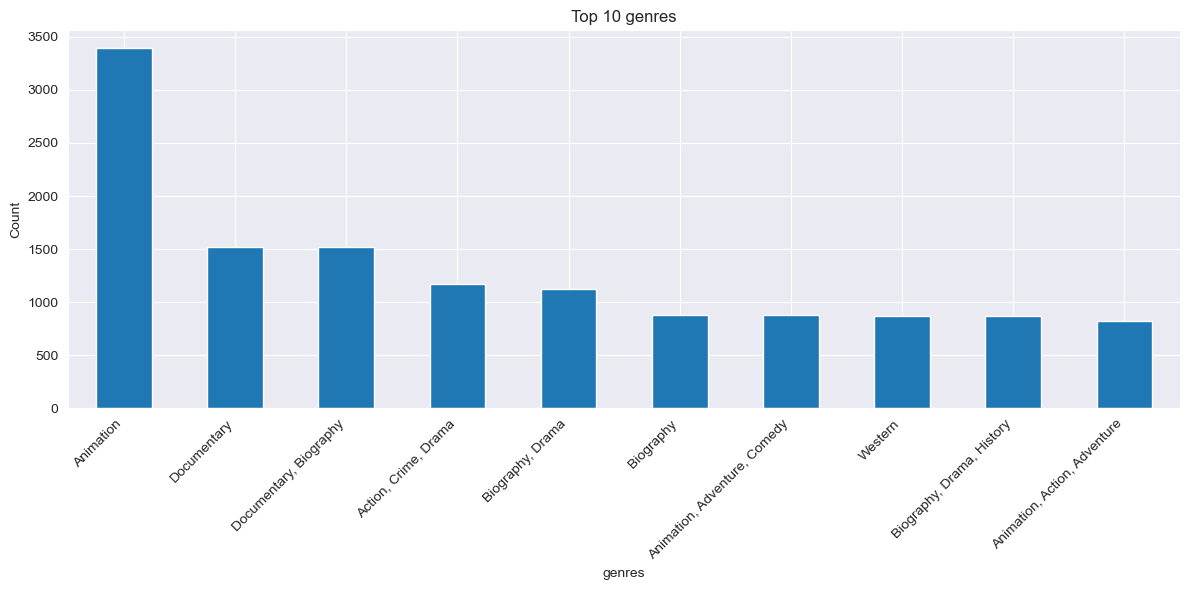

In [27]:
# 2.5 Analyze categorical data
categorical_cols = ['directors', 'writers', 'stars', 'origin_countries', 'languages', 'genres']

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    df[col].dropna().value_counts().nlargest(10).plot(kind='bar')
    plt.title(f'Top 10 {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


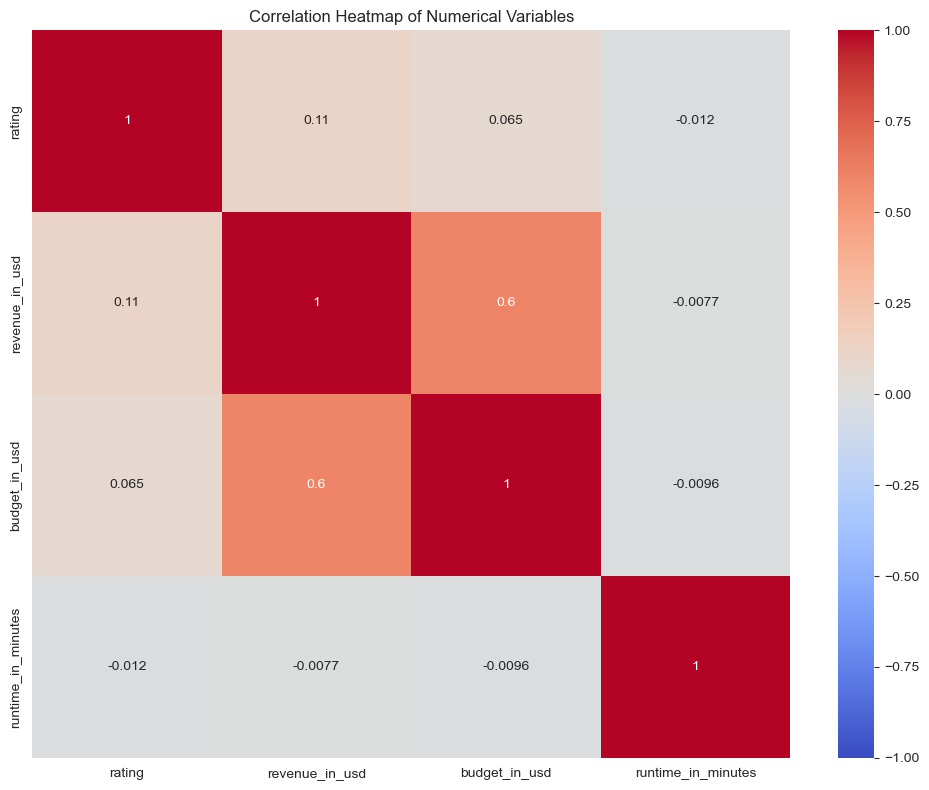

In [82]:
# generate_correlation_heatmap(_df=df)

utility.generate_correlation_heatmap(df=df, columns=numerical_cols, title="Correlation Heatmap of Numerical Variables")

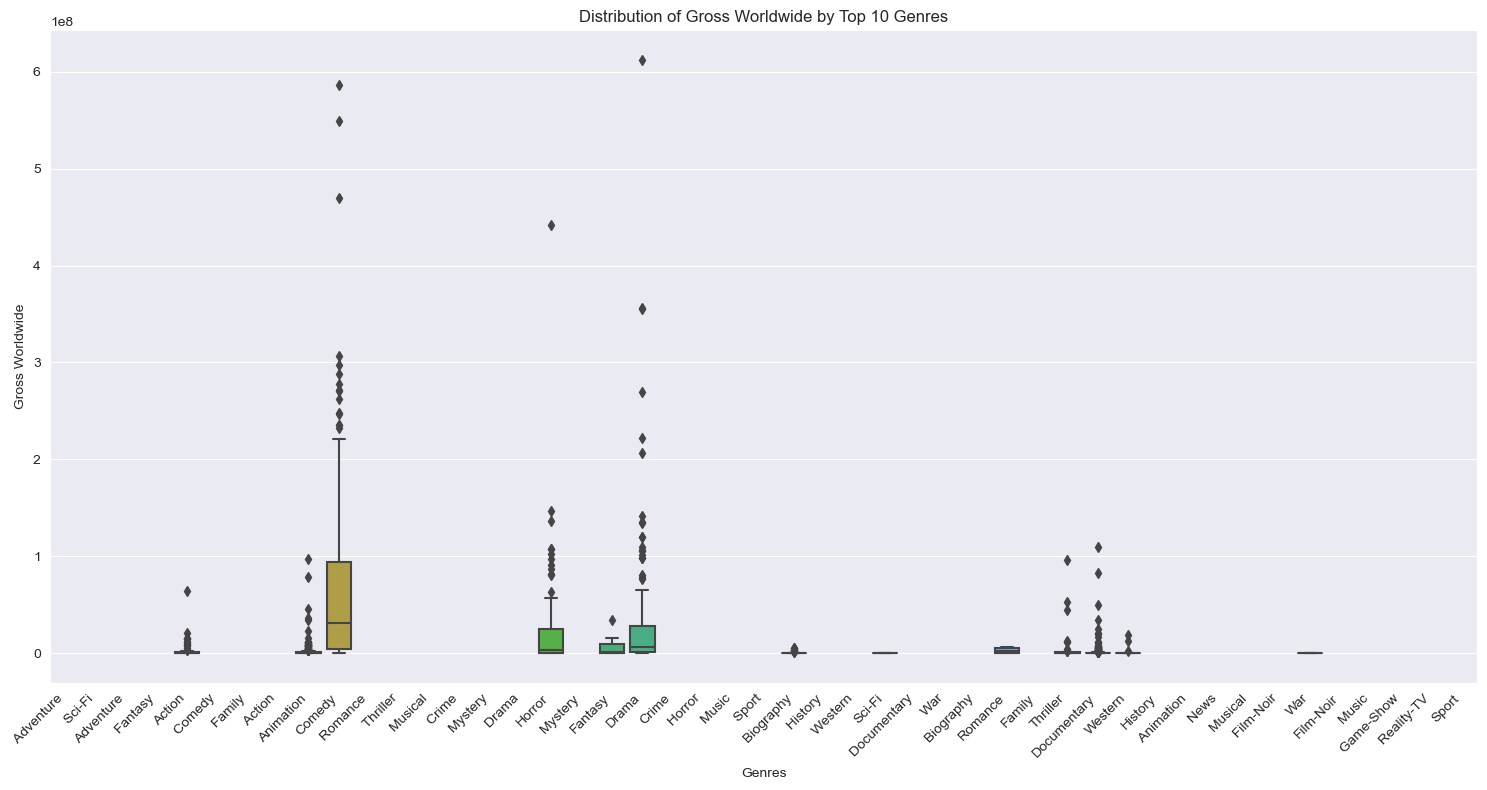

genres_split
 Adventure    1.117132e+08
 Sci-Fi       9.853647e+07
Adventure     8.142273e+07
 Fantasy      7.085559e+07
Action        6.698900e+07
 Comedy       6.213081e+07
 Family       5.419794e+07
 Action       4.710931e+07
Animation     4.440015e+07
Comedy        4.388722e+07
Name: revenue_in_usd, dtype: float64 47


In [29]:
# Box plot for 'Gross Worldwide' by 'genres'

# First, let's split the 'genres' column if it contains multiple genres per movie
df['genres_split'] = df['genres'].str.split(',')

# Explode the 'genres' column so each genre gets its own row
df_exploded = df.explode('genres_split')

# Calculate average `revenue in usd` for each genre
genre_avg = df_exploded.groupby('genres_split')['revenue_in_usd'].mean().sort_values(ascending=False)

# Get all genres
all_genres = genre_avg.head(48).index.tolist()

# Filter the dataframe to include all genres
df_top_10 = df_exploded[df_exploded['genres_split'].isin(all_genres)]

# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='genres', y='revenue_in_usd', data=df_top_10, order=all_genres)
plt.title('Distribution of Gross Worldwide by Top 10 Genres')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Gross Worldwide')
plt.xlabel('Genres')
plt.tight_layout()
plt.show()

# Print average Gross Worldwide for these top 10 genres
print(genre_avg.head(10), len(genre_avg))

3. Data Cleaning and Preprocessing:
    - 3.1 Handle missing values
    - 3.2 Remove duplicates
    - 3.3 Correct data types (ensure 'Budget' and 'Gross Worldwide', 'Runtime', etc. are numerical)
    - 3.4 Handle outliers:
        - 3.4.1 Detect outliers (boxplots and IQR)
        - 3.4.2 Apply treatment methods:
            - Quantile-based Flooring and Capping
            - Trimming
            - Log Transformation
    - 3.5 Compare and discuss outcomes of outlier treatments<br /><br />

#### 3.1 Handle Missing Values

In [30]:
# average percentage of missing values of all features
utility.average_percentage_missing_values(df)

id                     0.0
title                  0.0
rating                46.0
directors              7.0
writers                7.0
stars                  7.0
storyline              9.0
origin_countries       4.0
languages              7.0
budget                68.0
revenue               62.0
runtime                0.0
genres                 0.0
revenue_in_usd        62.0
budget_in_usd         71.0
runtime_in_minutes     0.0
genres_split           0.0
dtype: float64

##### Handling missing values for rating

In [31]:
# using KNNImputer to handle missing values of rating

rating_imputer = KNNImputer(n_neighbors=4)
df['rating'] = rating_imputer.fit_transform(np.reshape(df['rating'], (-1, 1)))

utility.average_percentage_missing_values(df['rating'])

0.0

##### Handling missing values for 

We will be handling the missing values by creating a new categorical feature <br />

NOTE: 'None' directors indicate that there are other directors on the movie production, 
who are not in the top 3 listed. <br />
It does not mean zero directors.

In [32]:
# to handle missing values, a new categorical feature will be created called director team

# create new 'director_team' feature
df['director_team'] = utility.categorize_column(df, 'directors')

# preview the distribution
df['director_team'].value_counts()

director_team
small           42185
not reported     3338
large            1123
Name: count, dtype: int64

##### Writer Feature - Handling missing values by creating a new categorical feature

In [33]:
# to handle missing values, a new categorical feature will be created called writer team

# create new 'writer_team' feature
df['writer_team'] = utility.categorize_column(df, 'writers')

# preview the distribution
df['writer_team'].value_counts()

writer_team
small           28507
large           14801
not reported     3338
Name: count, dtype: int64

##### Star Feature - Handling missing values by creating a new categorical feature

In [34]:
# to handle missing values, a new categorical feature will be created called star team

# create new 'star_team' feature
df['cast'] = utility.categorize_column(df, 'stars')

# preview the distribution
df['cast'].value_counts()

cast
large           36858
small            6450
not reported     3338
Name: count, dtype: int64

Origin Countries

According to IMDB website the feature Origin Countries is

* defines the place where the production company for the movie is located regardless of where filmed
*  multi-country production; countries are displayed in order entered
*  For locations where names or borders have changed; the name of the location at time of movie released is displayed

Solution:
* Create new feature which captures 4 classes based on top film producing markets; according to statista.com the top markets are United States, United Kingdom,France,China,India
* create new feature film_markets; classes: United States, United Kingdom,France,China,India, Other
* if it has more than one country, use the first country in the list to determine the designation.

Solution 2:

Considering the USA market to be significantly larger in number of movie produced per year, cumulative revenue grossing etc
The assumption is if there is a list of countries and USA is in the list, the movie production is benefitting from the "USA film market", in that it is being produced to be suitable for a USA market.
* could create feature film_markets ; yes - if united states, no- if other country

In [35]:
# Solution 2 will be used in this project

# create new feature
df['is_usa_film_market'] = utility.group_column_with_check(df, 'origin_countries', "United States")

# preview is_usa_film_market
df[['origin_countries', 'is_usa_film_market']].tail()

,origin_countries,is_usa_film_market
46641,Netherlands,no
46642,United States,yes
46643,Indonesia,no
46644,United States,yes
46645,Soviet Union,no


Languages

Similar to Origin Countries will create a feature called in_english; classes yes, not reported logic behind this feature follows on origin countries, considering the largest movie film market, which likely has the largest consumption market; the movie marketability and reach will be impacted by whether it has an english version.

In [36]:
# view values in Languages
df[['languages', 'origin_countries']].iloc[0:12]

,languages,origin_countries
0,"English, German",United Kingdom
1,English,"United States, United Kingdom"
2,English,"United States, United Kingdom"
3,English,United States
4,English,United States
5,English,Australia
6,English,United States
7,English,United States
8,"French, Latin, Greek, Ancient (to 1453), Italian","France, Italy"
9,Japanese,Japan


In [37]:
df['language_in_english'] = utility.group_column_with_check(df, 'languages', 'English')  #create new feature

# preview
df['language_in_english'].value_counts()

language_in_english
yes             30658
no              12777
not reported     3211
Name: count, dtype: int64

In [38]:
utility.missing_value_count(df['budget_in_usd'])

33174

##### Imputing NaN values in budget using KNN

In [39]:
df['budget_in_usd'] = KNNImputer(n_neighbors=4).fit_transform(np.reshape(df['budget_in_usd'], (-1, 1)))

# preview budget_in_usd column
utility.missing_value_count(df['budget_in_usd'])

0

##### Gross Worldwide - handle missing values

In [40]:
utility.average_percentage_missing_values(df['revenue_in_usd'])

62.0

In [41]:
df['revenue_in_usd'] = KNNImputer(n_neighbors=4).fit_transform(np.reshape(df['revenue_in_usd'], (-1, 1)))

# preview revenue_in_usd column
utility.missing_value_count(df['revenue_in_usd'])

0

##### Handling Genres column

In [42]:
print('missing value count before processing... ', utility.missing_value_count(df['genres']))

df['main_genre'] = df['genres'].apply(
    lambda genre: 'not reported' if pd.isnull(genre) else utility.transform_cells(genre)[0])

print('new column "main_genre" value count ', df['main_genre'].value_counts())

missing value count before processing...  74
new column "main_genre" value count  main_genre
Action          10015
Animation        9156
Documentary      7288
Biography        4987
Drama            4797
Comedy           3360
Horror           1750
Crime            1651
Adventure        1498
Western           893
Thriller          356
Fantasy           245
Mystery           154
Sci-Fi            136
Romance            89
War                77
not reported       74
Family             61
History            25
Musical            20
Film-Noir          10
Music               3
Sport               1
Name: count, dtype: int64


In [43]:
utility.missing_value_count(df['runtime_in_minutes'])

0

#### Storyline - Handle missing values

In [44]:
df['storyline'].fillna('unknown', inplace=True)

In [45]:
# Check all missing values handled and create a new dataframe free of missing values

df.columns

Index(['id', 'title', 'rating', 'directors', 'writers', 'stars', 'storyline',
       'origin_countries', 'languages', 'budget', 'revenue', 'runtime',
       'genres', 'revenue_in_usd', 'budget_in_usd', 'runtime_in_minutes',
       'genres_split', 'director_team', 'writer_team', 'cast',
       'is_usa_film_market', 'language_in_english', 'main_genre'],
      dtype='object')

In [46]:
df.shape

(46646, 23)

In [47]:
# remove duplicates in df
df.drop_duplicates(subset=['id'], inplace=True)
df.shape

(46646, 23)

In [48]:
df_not_null = df[[
    'id', 'title', 'rating', 'storyline', 'director_team', 'writer_team', 'cast', 'is_usa_film_market',
    'language_in_english', 'budget_in_usd', 'runtime_in_minutes', 'revenue_in_usd', 'main_genre',
]]

utility.average_percentage_missing_values(df_not_null)

id                     0.0
title                  0.0
rating                 0.0
storyline              0.0
director_team          0.0
writer_team            0.0
cast                   0.0
is_usa_film_market     0.0
language_in_english    0.0
budget_in_usd          0.0
runtime_in_minutes     0.0
revenue_in_usd         0.0
main_genre             0.0
dtype: float64

### 3.2 Remove/Handle Duplicates

In [49]:
# count of duplicated record
df_not_null.duplicated().sum()

0

### 3.3 Correct Data types

In [71]:
# convert to category

to_category_type = lambda _column: _column.astype('category')

columns_to_convert = ['writer_team', 'director_team', 'language_in_english', 'is_usa_film_market', 'cast']

for col in columns_to_convert:
    df_not_null.loc[:, col] = to_category_type(df_not_null.loc[:, col])

df_not_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46646 entries, 0 to 46645
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   46646 non-null  object 
 1   title                46573 non-null  object 
 2   rating               46646 non-null  float64
 3   storyline            46646 non-null  object 
 4   director_team        46646 non-null  object 
 5   writer_team          46646 non-null  object 
 6   cast                 46646 non-null  object 
 7   is_usa_film_market   46646 non-null  object 
 8   language_in_english  46646 non-null  object 
 9   budget_in_usd        46646 non-null  float64
 10  runtime_in_minutes   46646 non-null  int64  
 11  revenue_in_usd       46646 non-null  float64
 12  main_genre           46646 non-null  object 
 13  budget_in_usd_log    46646 non-null  float64
 14  revenue_in_usd_log   46646 non-null  float64
dtypes: float64(5), int64(1), object(9)
memory

In [51]:
df_not_null.loc[:, 'budget_in_usd'] = pd.to_numeric(df_not_null.loc[:, 'budget_in_usd'], errors='coerce')
df_not_null.loc[:, 'runtime_in_minutes'] = pd.to_numeric(df_not_null.loc[:, 'runtime_in_minutes'], errors='coerce')
df_not_null.loc[:, 'revenue_in_usd'] = pd.to_numeric(df_not_null.loc[:, 'revenue_in_usd'], errors='coerce')

df_not_null['budget_in_usd'].dtype, df_not_null['runtime_in_minutes'].dtype, df_not_null['revenue_in_usd'].dtype

(dtype('float64'), dtype('int64'), dtype('float64'))

### 3.4 Handle Outliers

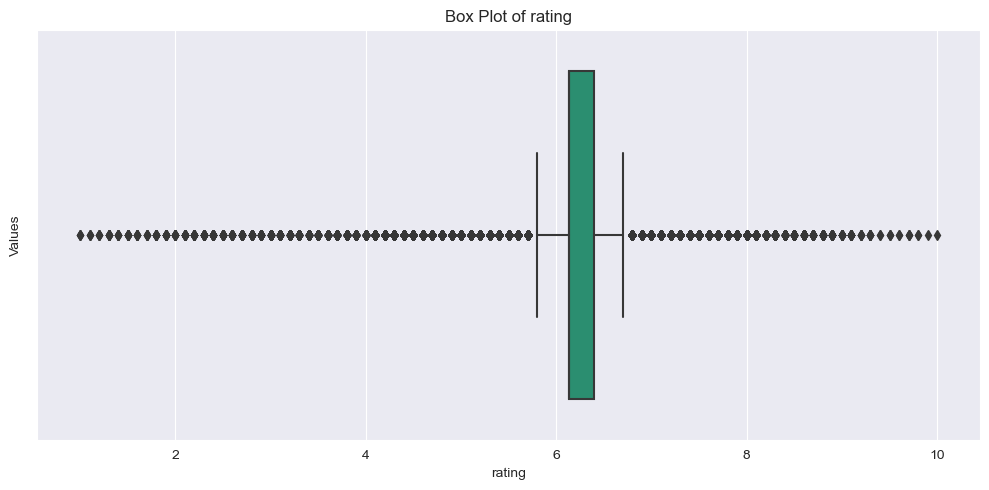

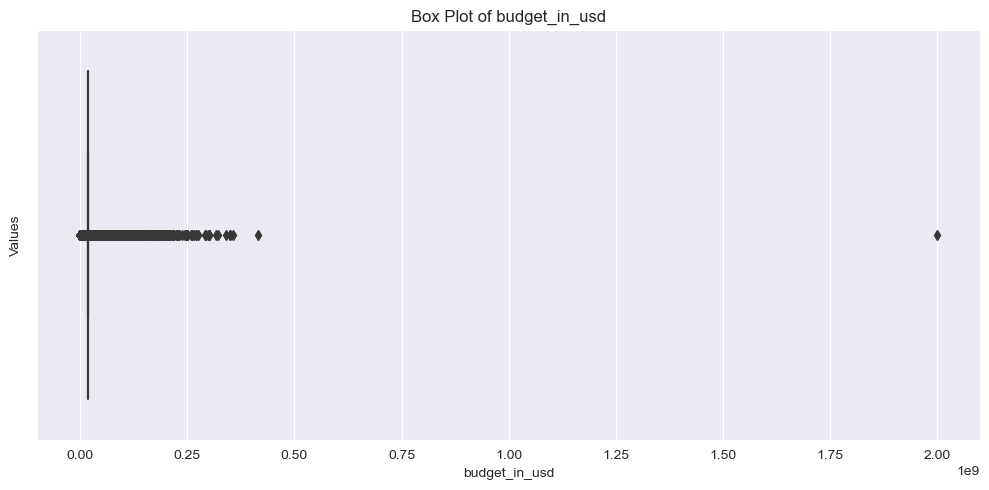

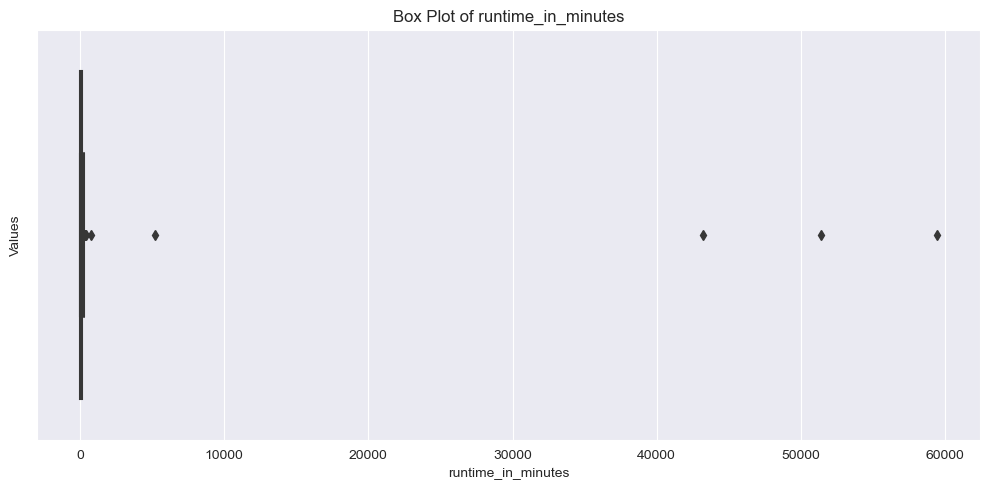

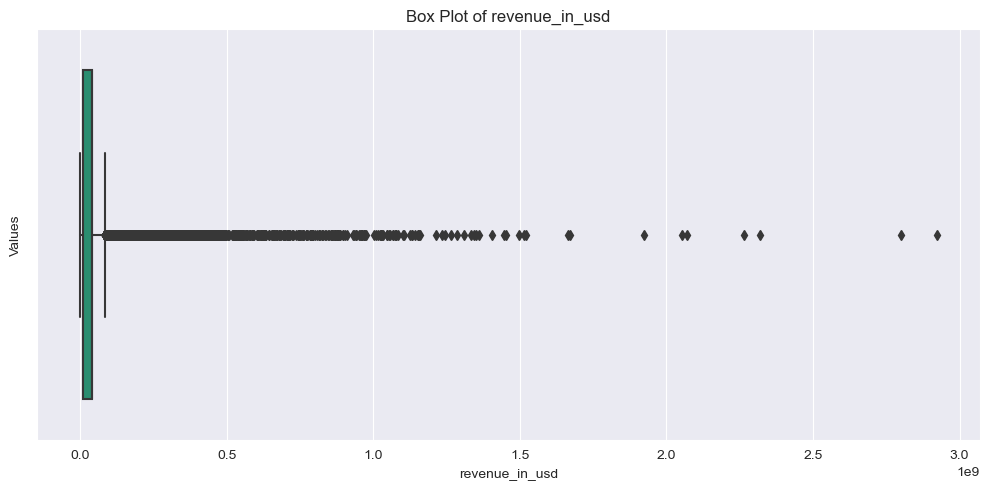

In [52]:
for column in df_not_null.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_not_null[column], palette='Dark2')
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.tight_layout()
    plt.show()

#### Detect with IQR

In [53]:
for column in df_not_null.select_dtypes(include='number').columns:
    print(f"Outlier count for feature {column} is: {outlier.iqr_range(df, df_not_null, column)}")

Outlier count for feature rating is: 16421
Outlier count for feature budget_in_usd is: 13472
Outlier count for feature runtime_in_minutes is: 11
Outlier count for feature revenue_in_usd is: 2014


### 3.4.2 Applying Treatment Methods

#### Quantile based flooring and capping

In [54]:
df_copy_iqr = df_not_null.copy()

In [55]:
for column in df_not_null.select_dtypes(include='number').columns:
    _floor, _cap = outlier.floor_cap(df, df_copy_iqr, column)
    print(f"Floor and Cap for the feature {column}: {_floor, _cap}")

Floor and Cap for the feature rating: (3.1, 8.3)
Floor and Cap for the feature budget_in_usd: (10000.0, 105000000.0)
Floor and Cap for the feature runtime_in_minutes: (0.0, 120.0)
Floor and Cap for the feature revenue_in_usd: (2347.1, 334616559.8500018)


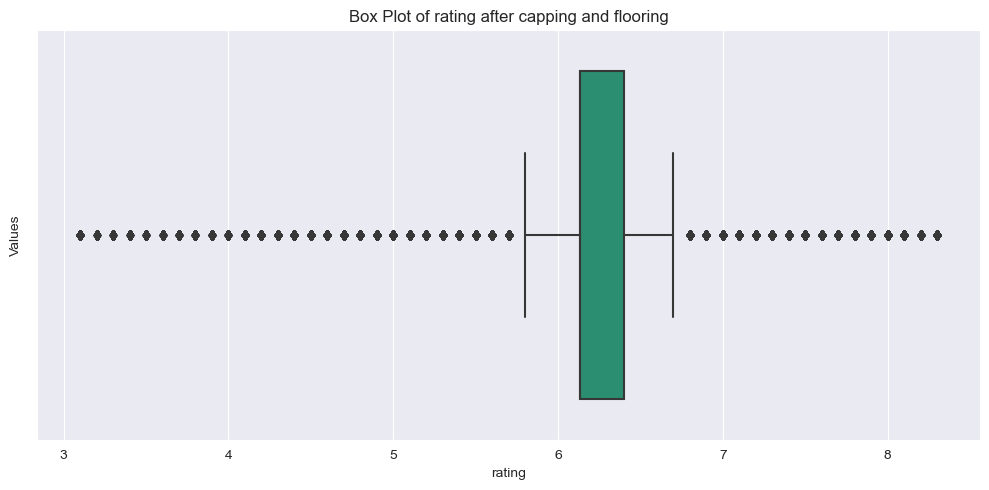

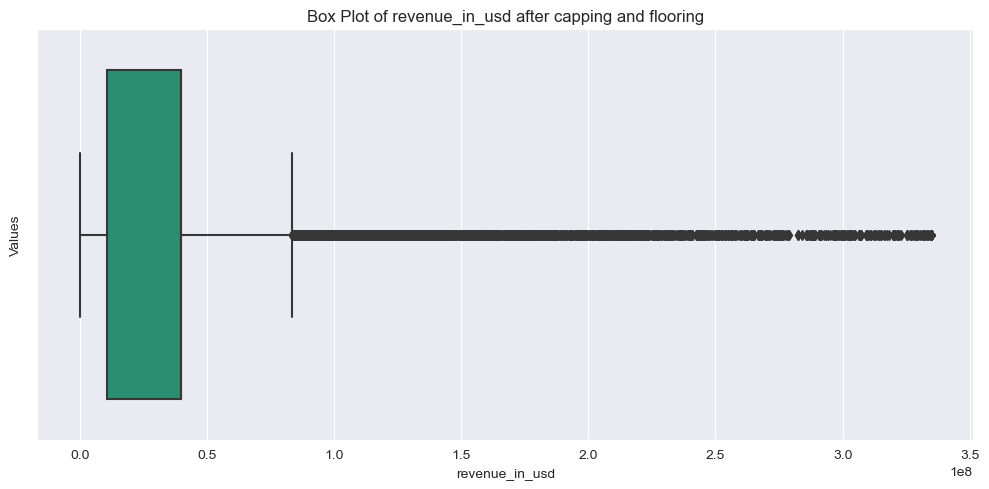

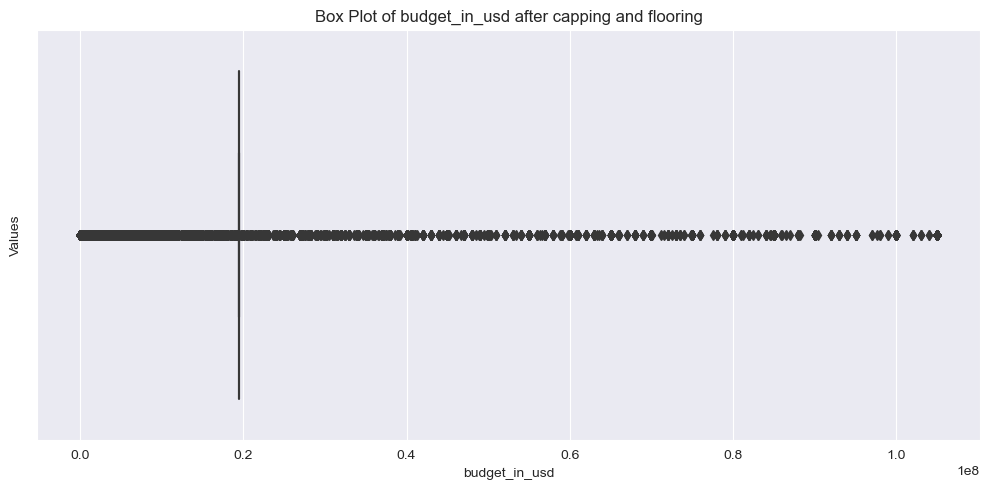

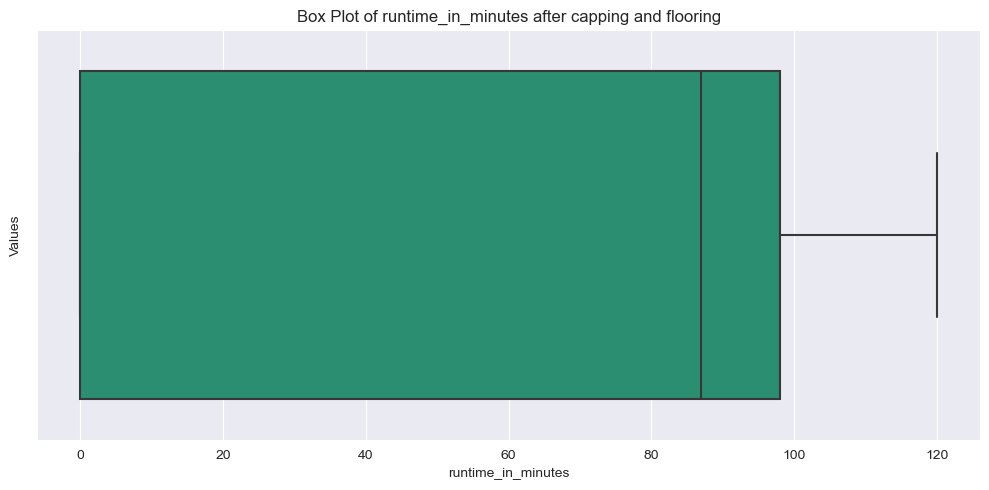

In [56]:
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_copy_iqr[column], palette='Dark2')
    plt.title(f'Box Plot of {column} after capping and flooring')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.tight_layout()
    plt.show()

### Trimming

In [57]:
df_copy_trimming = df_not_null.copy()

In [58]:
print('number of records in table: ', df_copy_trimming.shape[0])

number of records in table:  46646


In [59]:
df_copy_trimming = outlier.trimming(df_not_null, df_not_null.select_dtypes(include='number').columns)

print('number of records in table: ', df_copy_trimming.shape[0])

number of records in table:  13472


#### Log Transformation

In [60]:
df_copy_log = df_not_null.copy()

In [61]:
for column in ['budget_in_usd', 'revenue_in_usd']:
    df_copy_log[f'{column}_log'] = outlier.log_transformation(df_copy_log, column)

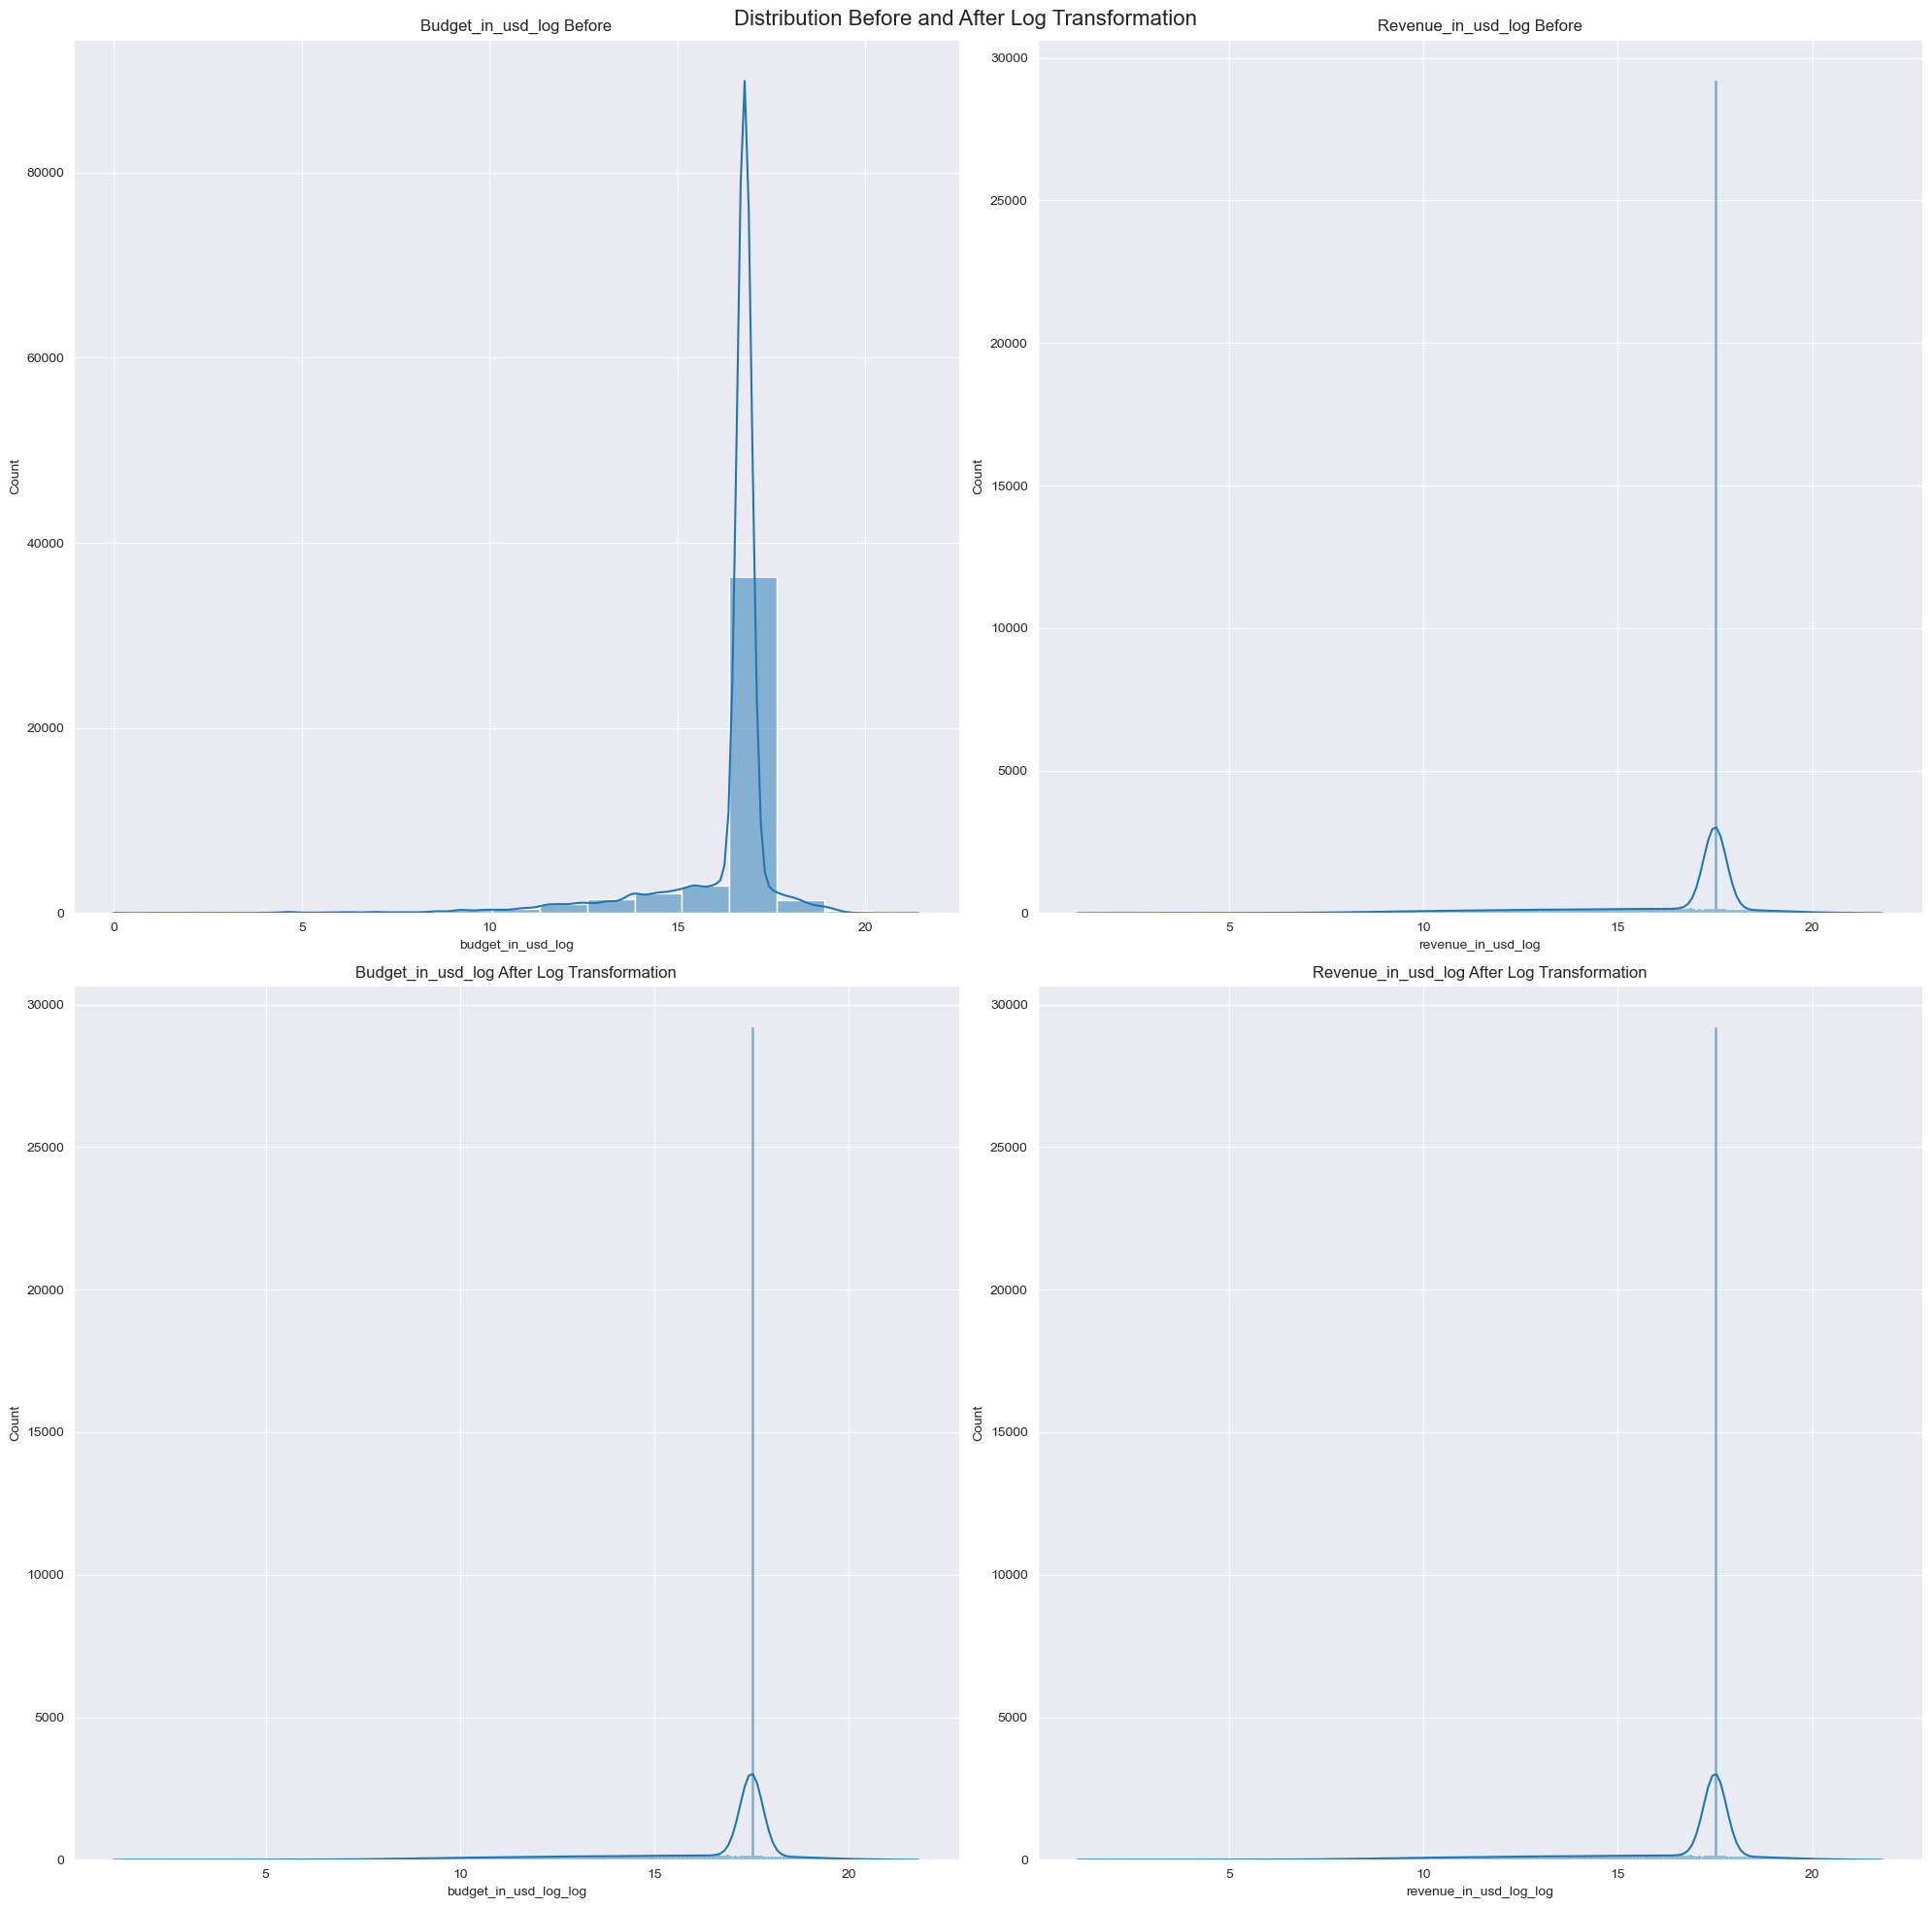

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Distribution Before and After Log Transformation', fontsize=16)

for i, col in enumerate(['budget_in_usd_log', 'revenue_in_usd_log']):
    sns.histplot(df_copy_log[col], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'{col.capitalize()} Before')
    axes[0, i].set_xlabel(col)

    sns.histplot(df_copy_log[f'{column}_log'], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'{col.capitalize()} After Log Transformation')
    axes[1, i].set_xlabel(f'{col}_log')

plt.tight_layout()
plt.show()

In [63]:
# add the values to the dataframe for analysis later

df_not_null.loc[:, ['budget_in_usd_log', 'revenue_in_usd_log']] \
    = df_copy_log.loc[:, ['budget_in_usd_log', 'revenue_in_usd_log']]

In [64]:
df_not_null.columns

Index(['id', 'title', 'rating', 'storyline', 'director_team', 'writer_team',
       'cast', 'is_usa_film_market', 'language_in_english', 'budget_in_usd',
       'runtime_in_minutes', 'revenue_in_usd', 'main_genre',
       'budget_in_usd_log', 'revenue_in_usd_log'],
      dtype='object')

In [65]:
df_not_null['budget_in_usd_log'].tail()

46641    16.783079
46642    16.783079
46643    16.783079
46644    16.783079
46645    16.783079
Name: budget_in_usd_log, dtype: float64

4. Feature Engineering:
    - 4.1 Encode categorical variables ('Directors', 'Writers', 'Stars', 'Origin Countries', 'Languages', 'Genres' etc)
    - 4.2 Extract features from 'Storyline' using NLP techniques
    - 4.3 Create new features if applicable (e.g., director/star popularity, genre combinations) **
    - 4.4 Normalize/standardize numerical features if needed<br /><br />

### 4.1 Encode categorical variables ('Directors', 'Writers', 'Stars/Cast', 'Origin Countries', 'Languages', 'Genres' etc)

In [66]:
encoder = OrdinalEncoder()
scaler = StandardScaler()

In [72]:
df_not_null.dtypes

id                      object
title                   object
rating                 float64
storyline               object
director_team           object
writer_team             object
cast                    object
is_usa_film_market      object
language_in_english     object
budget_in_usd          float64
runtime_in_minutes       int64
revenue_in_usd         float64
main_genre              object
budget_in_usd_log      float64
revenue_in_usd_log     float64
dtype: object

In [74]:
columns_categorical = ['writer_team', 'director_team', 'language_in_english', 'is_usa_film_market', 'cast']

columns_categorical

['writer_team',
 'director_team',
 'language_in_english',
 'is_usa_film_market',
 'cast']

In [85]:
df_copy_trimming.head()

,id,title,rating,storyline,director_team,writer_team,cast,is_usa_film_market,language_in_english,budget_in_usd,runtime_in_minutes,revenue_in_usd,main_genre
1,tt0098300,Shag,6.135405,Summer of 1963. Carson is getting married to h...,small,large,large,yes,yes,5000000.0,98,6.957975e+06,Comedy
2,tt1853739,You're Next,6.600000,When the Davison family comes under attack dur...,small,small,large,yes,yes,1000000.0,95,2.689548e+07,Drama
32772,tt1296869,The Keeper,5.000000,"Corrupt cop Sallinger, nearly killed by crooke...",small,small,large,yes,yes,6000000.0,94,3.974123e+07,Action
32773,tt1714206,The Spectacular Now,7.000000,A hard-partying high school senior's philosoph...,small,large,large,yes,yes,2500000.0,95,6.918591e+06,Drama
6,tt0082406,The Fox and the Hound,7.200000,A fox named Tod and a hound named Copper vow t...,large,large,large,yes,yes,12000000.0,83,6.345699e+07,Animation


In [86]:
df_not_null.loc[:, columns_categorical] = encoder.fit_transform(df_not_null.loc[:, columns_categorical])
df_not_null.loc[:, 'main_genre'] = encoder.fit_transform(df_not_null.loc[:, ['main_genre']])

df_copy_trimming.loc[:, columns_categorical] = encoder.fit_transform(df_copy_trimming.loc[:, columns_categorical])
df_copy_trimming.loc[:, 'main_genre'] = encoder.fit_transform(df_copy_trimming.loc[:, ['main_genre']])

df_copy_iqr.loc[:, columns_categorical] = encoder.fit_transform(df_copy_iqr.loc[:, columns_categorical])
df_copy_iqr.loc[:, 'main_genre'] = encoder.fit_transform(df_copy_iqr.loc[:, ['main_genre']])

df_not_null.head()

,id,title,rating,storyline,director_team,writer_team,cast,is_usa_film_market,language_in_english,budget_in_usd,runtime_in_minutes,revenue_in_usd,main_genre,budget_in_usd_log,revenue_in_usd_log
0,tt0060437,Funeral in Berlin,7.424700e-01,Sent to East Berlin to retrieve a Communist de...,2.0,2.0,0.0,0.0,2.0,-4.173749e-17,0.073154,-5.253698e-01,19.0,0.311687,-4.425893
1,tt0098300,Shag,1.782156e-16,Summer of 1963. Carson is getting married to h...,2.0,0.0,0.0,2.0,2.0,-6.871992e-01,0.063575,-4.333890e-01,4.0,-0.509547,-0.225257
2,tt1853739,You're Next,5.190347e-01,When the Davison family comes under attack dur...,2.0,2.0,0.0,2.0,2.0,-8.774988e-01,0.056392,-1.698186e-01,7.0,-1.482742,0.313298
3,tt22036900,Covid Karma,1.782156e-16,An Indian film maker is stuck in USA for five ...,2.0,0.0,2.0,2.0,2.0,-4.173749e-17,-0.171095,5.369513e-18,3.0,0.311687,0.468814
4,tt0419434,American Hardcore,1.782156e-16,The History of American Punk Rock 1980-1986,2.0,2.0,0.0,2.0,2.0,-4.173749e-17,0.068365,-5.204008e-01,6.0,0.311687,-1.387513


### - 4.2 Extract features from 'Storyline' using NLP techniques

In [76]:
# Extract features from 'Storyline' using NLP techniques
df['storyline'] = df['storyline'].astype(str)
df['cleaned_storyline'] = (df['storyline']
                           .apply(text_wrangler.remove_digit)
                           .apply(text_wrangler.remove_punctuations)
                           .apply(text_wrangler.clean_text)
                           .apply(text_wrangler.word_lengthening)
                           .apply(text_wrangler.remove_stopwords)
                           .apply(text_wrangler.lemmatizer))

# - 4.3 Create new features if applicable 

done below...

 #### - 4.4 Normalize/standardize numerical features if needed

In [83]:
numerical_cols.extend(['budget_in_usd_log', 'revenue_in_usd_log'])

In [84]:
df_not_null.loc[:, numerical_cols] = scaler.fit_transform(df_not_null.loc[:, numerical_cols])

In [88]:
other_numerical_cols = ['rating',
                        'revenue_in_usd',
                        'budget_in_usd',
                        'runtime_in_minutes', ]

df_copy_trimming.loc[:, other_numerical_cols] = scaler.fit_transform(df_copy_trimming.loc[:, other_numerical_cols])

df_copy_iqr.loc[:, other_numerical_cols] = scaler.fit_transform(df_copy_iqr.loc[:, other_numerical_cols])

In [339]:
df_not_null[['rating', 'budget_in_usd', 'revenue_in_usd', 'runtime_in_minutes', 'budget_in_usd_log',
             'revenue_in_usd_log']].describe()

,rating,budget_in_usd,revenue_in_usd,runtime_in_minutes,budget_in_usd_log,revenue_in_usd_log
count,4.664600e+04,4.664600e+04,4.664600e+04,4.664600e+04,4.664600e+04,4.664600e+04
mean,1.806289e-15,4.173749e-17,-5.369513e-18,6.093065e-18,1.913755e-15,-1.171087e-15
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-5.737155e+00,-9.250737e-01,-5.253722e-01,-1.710954e-01,-9.836708e+00,-6.063331e+00
25%,1.984505e-15,0.000000e+00,-3.840661e-01,-1.710954e-01,3.116873e-01,-5.424982e-02
50%,1.984505e-15,0.000000e+00,0.000000e+00,3.723471e-02,3.116873e-01,4.688139e-01
75%,2.955993e-01,0.000000e+00,0.000000e+00,6.357530e-02,3.116873e-01,4.688139e-01
max,4.317436e+00,9.422474e+01,3.812552e+01,1.422118e+02,3.113373e+00,2.180875e+00


5. Feature Selection:
    - 5.1 Identify most important features for predicting 'Gross Worldwide' / revenue_usd
    - 5.2 Use correlation analysis or feature importance techniques<br /><br />


5.1 will be done in section 7

In [341]:
df_not_null.columns

Index(['id', 'title', 'rating', 'storyline', 'director_team', 'writer_team',
       'cast', 'is_usa_film_market', 'language_in_english', 'budget_in_usd',
       'runtime_in_minutes', 'revenue_in_usd', 'main_genre',
       'budget_in_usd_log', 'revenue_in_usd_log'],
      dtype='object')

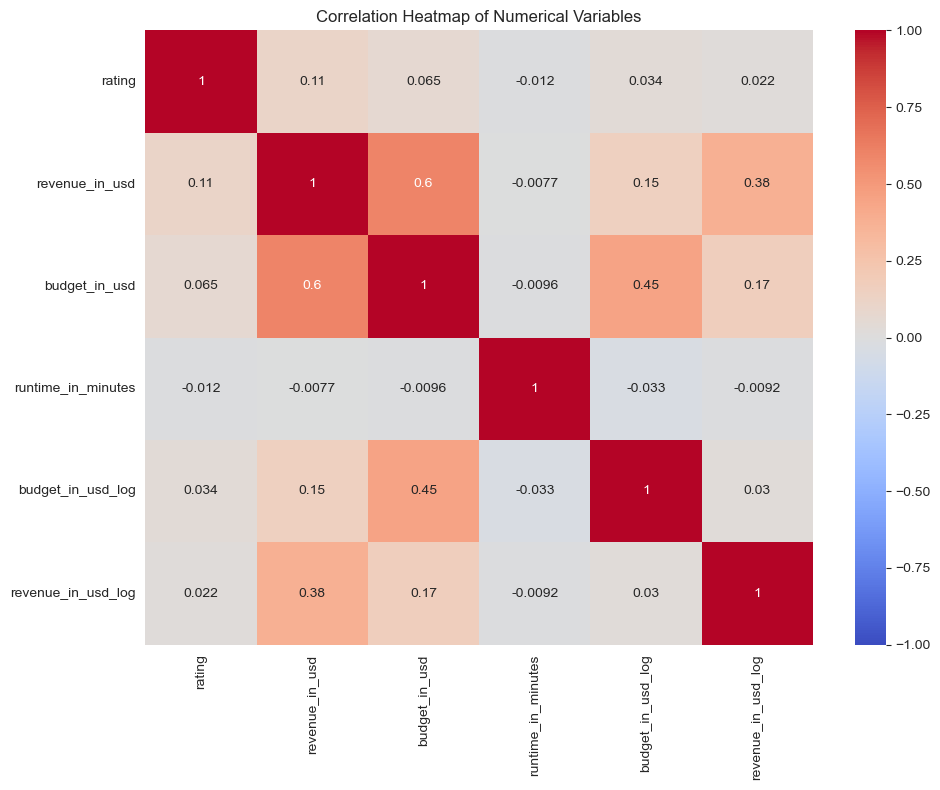

In [89]:
utility.generate_correlation_heatmap(df_not_null, numerical_cols,
                                     title="Correlation Heatmap of Numerical Variables with Log Transformation")

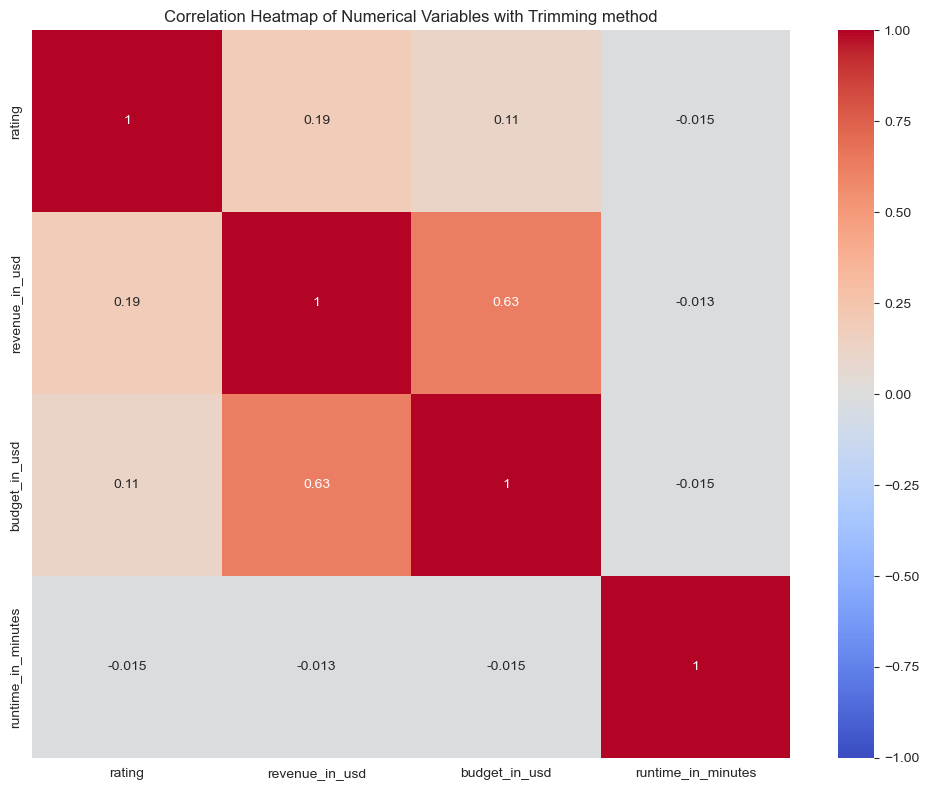

In [90]:
utility.generate_correlation_heatmap(df_copy_trimming, other_numerical_cols,
                                     title="Correlation Heatmap of Numerical Variables with Trimming method")

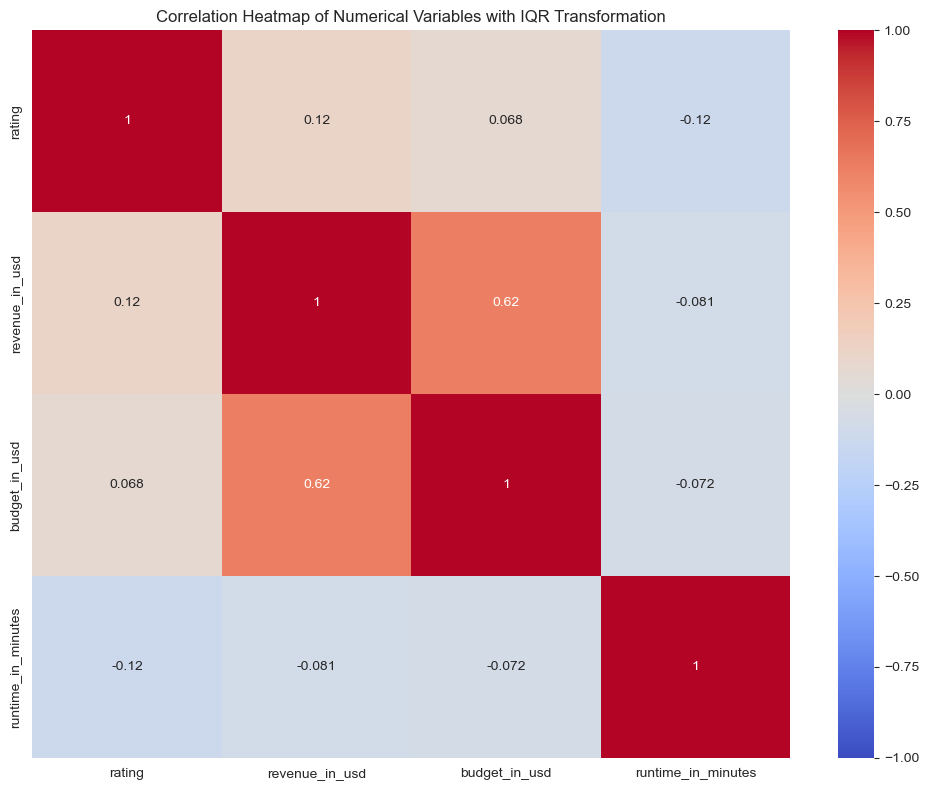

In [91]:
utility.generate_correlation_heatmap(df_copy_iqr, other_numerical_cols,
                                     title="Correlation Heatmap of Numerical Variables with IQR Transformation")

6. Natural Language Processing (if applicable):
    - 6.1 Text data cleaning
    - 6.2 Tokenization
    - 6.3 Stop word and punctuation removal
    - 6.4 Stemming or lemmatization<br /><br />


In [92]:
df['cleaned_storyline'].head()

0    send east berlin retrieve communist defector b...
1    summer carson get married boyfriend friend mel...
2    davison family come attack wedding anniversary...
3    indian film maker stick usa five month global ...
4                           history american punk rock
Name: cleaned_storyline, dtype: object

In [93]:
df['cleaned_title'] = (df['title']
                       .apply(str)
                       .apply(text_wrangler.remove_digit)
                       .apply(text_wrangler.remove_punctuations)
                       .apply(text_wrangler.clean_text)
                       .apply(text_wrangler.word_lengthening)
                       .apply(text_wrangler.remove_stopwords)
                       .apply(text_wrangler.lemmatizer))

In [96]:
df_not_null.loc[:, 'storyline_polarity'] = df_not_null.loc[:, 'storyline'].apply(
    text_sentiment_analysis.get_sentiment_via_vader)
df_not_null.loc[:, 'title_polarity'] = (df_not_null.loc[:, 'title'].apply(str).apply(
    text_sentiment_analysis.get_sentiment_via_vader))

df_copy_trimming.loc[:, 'storyline_polarity'] = df_copy_trimming['storyline'].apply(
    text_sentiment_analysis.get_sentiment_via_vader)
df_copy_trimming.loc[:, 'title_polarity'] = (df_copy_trimming['title'].apply(str).apply(
    text_sentiment_analysis.get_sentiment_via_vader))

df_copy_iqr.loc[:, 'storyline_polarity'] = df_copy_iqr['storyline'].apply(
    text_sentiment_analysis.get_sentiment_via_vader)
df_copy_iqr.loc[:, 'title_polarity'] = (df_copy_iqr['title'].apply(str).apply(
    text_sentiment_analysis.get_sentiment_via_vader))

In [99]:
numerical_cols.extend(['storyline_polarity', 'title_polarity'])
other_numerical_cols.extend(['storyline_polarity', 'title_polarity'])

df_not_null[numerical_cols].head()

,rating,revenue_in_usd,budget_in_usd,runtime_in_minutes,budget_in_usd_log,revenue_in_usd_log,storyline_polarity,title_polarity,storyline_polarity,title_polarity,storyline_polarity,title_polarity
0,7.424700e-01,-5.253698e-01,-4.173749e-17,0.073154,0.311687,-4.425893,-0.7219,-0.3612,-0.7219,-0.3612,-0.7219,-0.3612
1,1.782156e-16,-4.333890e-01,-6.871992e-01,0.063575,-0.509547,-0.225257,0.1226,0.0000,0.1226,0.0000,0.1226,0.0000
2,5.190347e-01,-1.698186e-01,-8.774988e-01,0.056392,-1.482742,0.313298,-0.8555,0.0000,-0.8555,0.0000,-0.8555,0.0000
3,1.782156e-16,5.369513e-18,-4.173749e-17,-0.171095,0.311687,0.468814,-0.7650,0.0000,-0.7650,0.0000,-0.7650,0.0000
4,1.782156e-16,-5.204008e-01,-4.173749e-17,0.068365,0.311687,-1.387513,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


7. Model Selection and Training:
    - 7.1 Split data into training and testing sets
    - 7.2 Select and train multiple regression models (e.g., Linear Regression, Random Forest, Gradient Boosting)
    - 7.3 Perform cross-validation<br /><br />


In [167]:
class SupervisedModel:
    def __init__(self):
        pass

    @staticmethod
    def get_x_and_y(df, is_log=False):
        if is_log:
            X = df_not_null[
                ['rating', 'director_team', 'writer_team', 'cast', 'is_usa_film_market', 'language_in_english',
                 'budget_in_usd_log', 'runtime_in_minutes', 'main_genre', 'storyline_polarity',
                 'title_polarity']]
            y = df_not_null['revenue_in_usd_log']

            return X, y
        else:
            X = df[['rating', 'director_team', 'writer_team', 'cast', 'is_usa_film_market', 'language_in_english',
                    'budget_in_usd', 'runtime_in_minutes', 'main_genre', 'storyline_polarity', 'title_polarity']]
            y = df['revenue_in_usd']

            return X, y

    @staticmethod
    def split_data(X, y):
        return train_test_split(X, y, test_size=0.4, random_state=42)

    @staticmethod
    def linear_model(X_train, y_train):
        # Initialize the model
        model = LinearRegression()

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)

        print(f"Cross-Validation RMSE: {cv_rmse}")
        print(f"Mean CV RMSE: {cv_rmse.mean()}")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"Test RMSE: {rmse}")

        #rsquared
        r_squared1 = model.score(X_train, y_train)
        r_squared2 = model.score(X_test, y_test)

        print(r_squared1)
        print(r_squared2)
        return y_pred

    @staticmethod
    def random_forest_model(X_train, y_train):
        # Initialize the model
        model = RandomForestRegressor()

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)

        print(f"Cross-Validation RMSE: {cv_rmse}")
        print(f"Mean CV RMSE: {cv_rmse.mean()}")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"Test RMSE: {rmse}")

        #rsquared
        r_squared1 = model.score(X_train, y_train)
        r_squared2 = model.score(X_test, y_test)

        print(r_squared1)
        print(r_squared2)
        return y_pred

    @staticmethod
    def xgboost_model(X_train, y_train):
        model = xgb.XGBRegressor()

        # dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)

        print(f"Cross-Validation RMSE: {cv_rmse}")
        print(f"Mean CV RMSE: {cv_rmse.mean()}")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"Test RMSE: {rmse}")

        #rsquared
        r_squared1 = model.score(X_train, y_train)
        r_squared2 = model.score(X_test, y_test)

        print(r_squared1)
        print(r_squared2)
        return y_pred

    @staticmethod
    def ridge_model(X_train, y_train):
        model = Ridge()

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)

        print(f"Cross-Validation RMSE: {cv_rmse}")
        print(f"Mean CV RMSE: {cv_rmse.mean()}")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"Test RMSE: {rmse}")

        #rsquared
        r_squared1 = model.score(X_train, y_train)
        r_squared2 = model.score(X_test, y_test)

        print(r_squared1)
        print(r_squared2)
        return y_pred

    @staticmethod
    def plot_result(y_test, y_pred):
        # Convert y_test and y_pred to a DataFrame for easier plotting with Seaborn
        results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

        # Plot the scatter plot using Seaborn
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.3)
        sns.lineplot(x='Actual', y='Actual', data=results_df, color='red', linestyle='--')
        plt.xlabel('Actual Revenue in USD')
        plt.ylabel('Predicted Revenue in USD')
        plt.title('Actual vs Predicted Revenue')
        plt.show()


supervised_model = SupervisedModel()

In [184]:
affected_columns = ['director_team', 'writer_team', 'cast', 'is_usa_film_market', 'language_in_english', 'main_genre']

for column_name in affected_columns:
    df_not_null.loc[:, column_name] = pd.to_numeric(df_not_null.loc[:, column_name], errors='coerce')
    df_copy_trimming[column_name] = pd.to_numeric(df_copy_trimming[column_name], errors='coerce')
    df_copy_iqr[column_name] = pd.to_numeric(df_copy_iqr[column_name], errors='coerce')

In [186]:
# using the default value
X, y = supervised_model.get_x_and_y(df_not_null)
X_log, y_log = supervised_model.get_x_and_y(df_not_null)
X_trim, y_trim = supervised_model.get_x_and_y(df_copy_trimming)
X_iqr, y_iqr = supervised_model.get_x_and_y(df_copy_iqr)

In [187]:
df_not_null.select_dtypes(include="number").columns

Index(['rating', 'director_team', 'writer_team', 'cast', 'is_usa_film_market',
       'language_in_english', 'budget_in_usd', 'runtime_in_minutes',
       'revenue_in_usd', 'main_genre', 'budget_in_usd_log',
       'revenue_in_usd_log', 'storyline_polarity', 'title_polarity'],
      dtype='object')

In [188]:
# Train-test split
X_train, X_test, y_train, y_test = supervised_model.split_data(X, y)

X_train_log, X_test_log, y_train_log, y_test_log = supervised_model.split_data(X_log, y_log)

X_train_trim, X_test_trim, y_train_trim, y_test_trim = supervised_model.split_data(X_trim, y_trim)

X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = supervised_model.split_data(X_iqr, y_iqr)

### Lineal regresion model

In [189]:
y_pred = supervised_model.linear_model(X_train, y_train)

Cross-Validation RMSE: [0.69790812 0.64267462 0.69589042 0.79199553 0.77918133]
Mean CV RMSE: 0.7215300040728283
Test RMSE: 0.8992032436741918
0.4679746408714329
0.21169878428619082


In [190]:
y_pred_log = supervised_model.linear_model(X_train_log, y_train_log)

Cross-Validation RMSE: [0.69790812 0.64267462 0.69589042 0.79199553 0.77918133]
Mean CV RMSE: 0.7215300040728283
Test RMSE: 0.8992032436741918
0.4679746408714329
0.21169878428619082


In [191]:
y_pred_trim = supervised_model.linear_model(X_train_trim, y_train_trim)

Cross-Validation RMSE: [0.63201441 0.71597847 0.77533257 1.21695745 0.6847354 ]
Mean CV RMSE: 0.8050036610568707
Test RMSE: 1.162130738079246
0.38308980899662826
-0.3166988106689943


In [192]:
y_pred_iqr = supervised_model.linear_model(X_train_iqr, y_train_iqr)

Cross-Validation RMSE: [0.79319539 0.77318426 0.7518842  0.79502542 0.79549303]
Mean CV RMSE: 0.7817564588370192
Test RMSE: 0.8771513695846008
0.4242945276445761
0.24988895844961379


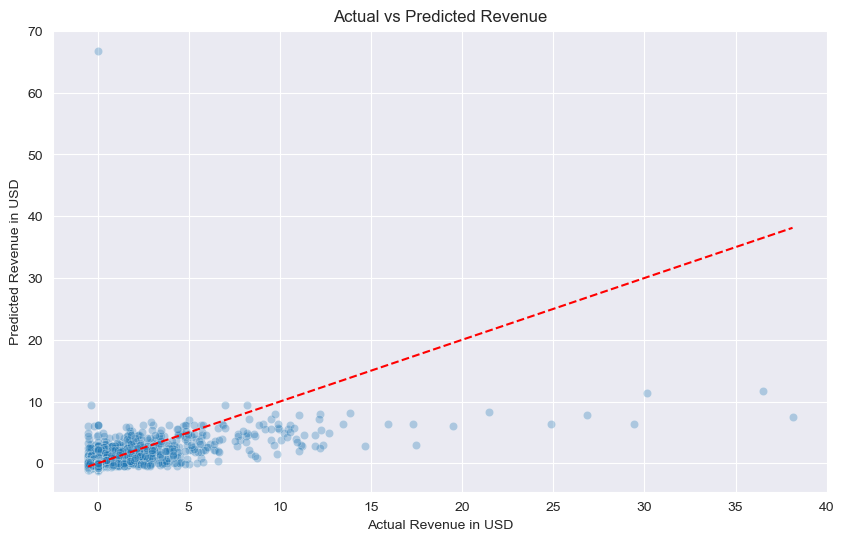

In [193]:
supervised_model.plot_result(y_test, y_pred)

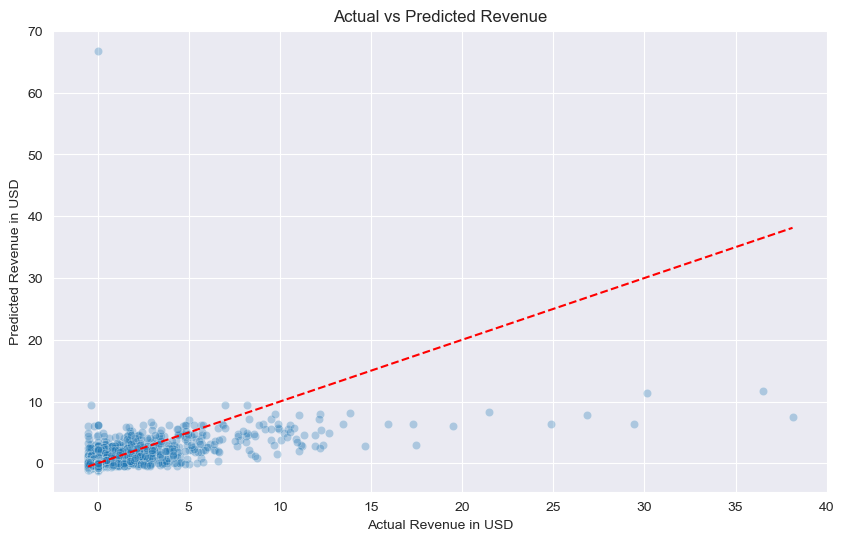

In [194]:
supervised_model.plot_result(y_test_log, y_pred_log)

In [195]:
# supervised_model.plot_result(y_test_trim, y_pred_trim)

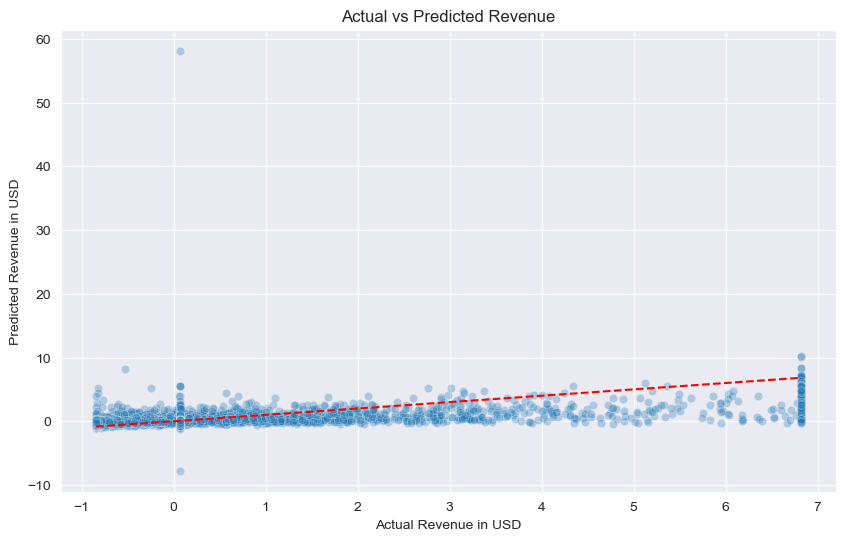

In [196]:
supervised_model.plot_result(y_test_iqr, y_pred_iqr)

### RandomForestRegressor()

In [197]:
y_pred = supervised_model.random_forest_model(X_train, y_train)

Cross-Validation RMSE: [0.68392513 0.5503463  0.65511982 0.70925647 0.7245755 ]
Mean CV RMSE: 0.6646446462670736
Test RMSE: 0.6567565058517236
0.935372749250769
0.5794813767776992


In [141]:
y_pred_log = supervised_model.random_forest_model(X_train_log, y_train_log)

Cross-Validation RMSE: [0.69482488 0.55005926 0.64465692 0.70750749 0.71910136]
Mean CV RMSE: 0.663229981728886
Test RMSE: 0.6597174126665746
0.9338124848642039
0.5756811154199701


In [147]:
y_pred_trim = supervised_model.random_forest_model(X_train_trim, y_train_trim)

Cross-Validation RMSE: [0.57391211 0.65038606 0.70854917 0.74955908 0.65376253]
Mean CV RMSE: 0.6672337893288652
Test RMSE: 0.702525696842255
0.9364080386947055
0.5188273926539293


In [148]:
y_pred_iqr = supervised_model.random_forest_model(X_train_iqr, y_train_iqr)

Cross-Validation RMSE: [0.72531073 0.65811204 0.68096886 0.71466246 0.70806116]
Mean CV RMSE: 0.6974230492859552
Test RMSE: 0.7787461796263563
0.9313667488516232
0.4087538512495278


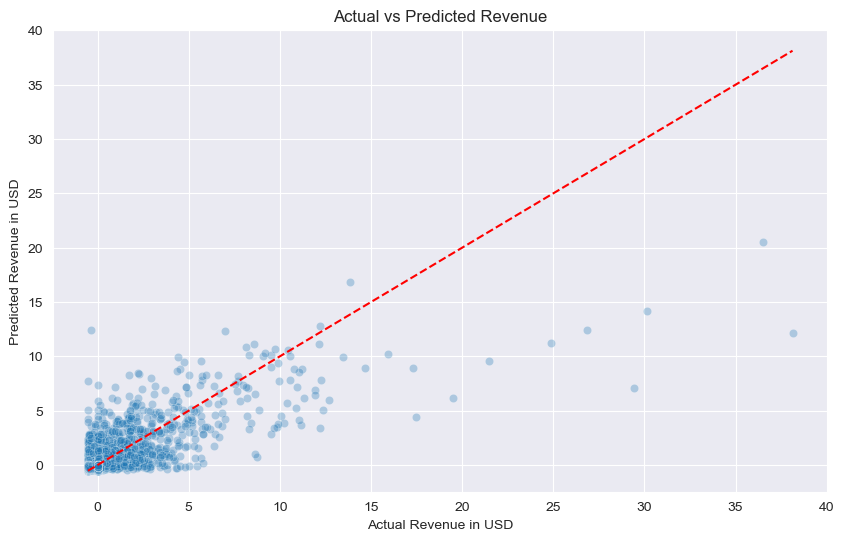

In [149]:
supervised_model.plot_result(y_test, y_pred)

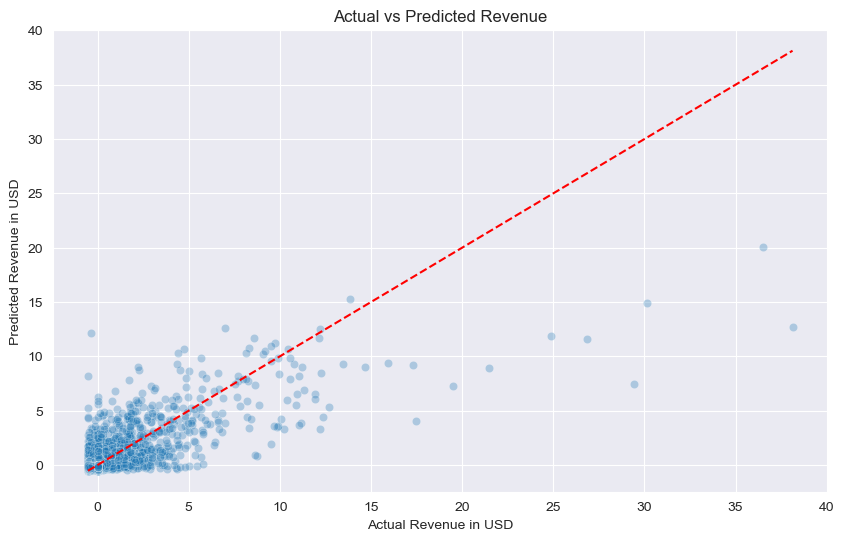

In [150]:
supervised_model.plot_result(y_test_log, y_pred_log)

In [153]:
# supervised_model.plot_result(y_test_trim, y_pred_trim)

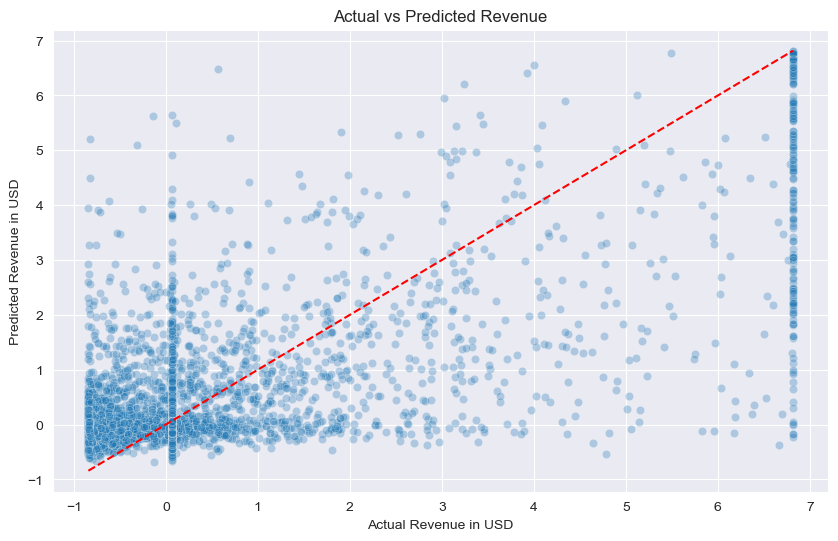

In [152]:
supervised_model.plot_result(y_test_iqr, y_pred_iqr)

### xgboost model

In [198]:
X_train

,rating,director_team,writer_team,cast,is_usa_film_market,language_in_english,budget_in_usd,runtime_in_minutes,main_genre,storyline_polarity,title_polarity
24797,1.412776e+00,2.0,2.0,0.0,2.0,2.0,-4.173749e-17,0.061181,5.0,-0.9217,0.0000
42900,4.073170e-01,2.0,0.0,0.0,2.0,2.0,3.594542e+00,0.039629,2.0,-0.0772,0.0000
5599,-3.747068e-01,2.0,2.0,0.0,0.0,2.0,-4.173749e-17,0.061181,12.0,-0.8885,0.0000
41538,2.955993e-01,2.0,2.0,0.0,2.0,2.0,-4.173749e-17,-0.039392,7.0,-0.6124,0.0000
14275,1.782156e-16,2.0,2.0,0.0,2.0,2.0,-4.173749e-17,-0.171095,7.0,0.7003,0.4019
...,...,...,...,...,...,...,...,...,...,...,...
11284,5.190347e-01,2.0,0.0,0.0,0.0,0.0,-4.173749e-17,0.056392,2.0,-0.4588,0.2960
44732,1.782156e-16,0.0,2.0,0.0,2.0,2.0,-4.173749e-17,-0.032209,6.0,0.4404,0.0000
38158,7.424700e-01,2.0,0.0,0.0,2.0,2.0,-8.361087e-01,0.056392,4.0,0.8885,0.0000
860,1.782156e-16,2.0,0.0,0.0,2.0,0.0,-4.173749e-17,-0.171095,0.0,0.2023,0.0000


In [199]:
y_pred = supervised_model.xgboost_model(X_train, y_train)

Cross-Validation RMSE: [0.72551094 0.58838719 0.67868017 0.7806639  0.76920628]
Mean CV RMSE: 0.7084896938138124
Test RMSE: 0.7066271653769082
0.8993935189036402
0.5131926516631863


In [200]:
y_pred_log = supervised_model.xgboost_model(X_train_log, y_train_log)

Cross-Validation RMSE: [0.72551094 0.58838719 0.67868017 0.7806639  0.76920628]
Mean CV RMSE: 0.7084896938138124
Test RMSE: 0.7066271653769082
0.8993935189036402
0.5131926516631863


In [201]:
y_pred_trim = supervised_model.xgboost_model(X_train_trim, y_train_trim)

Cross-Validation RMSE: [0.65712321 0.68934979 0.77732175 0.81441751 0.67731635]
Mean CV RMSE: 0.7231057225489669
Test RMSE: 0.7174507968726462
0.958727606506259
0.4981652729960768


In [202]:
y_pred_iqr = supervised_model.xgboost_model(X_train_iqr, y_train_iqr)

Cross-Validation RMSE: [0.74024667 0.67350952 0.67220609 0.73966892 0.70527515]
Mean CV RMSE: 0.7061812686601148
Test RMSE: 0.8551520099819138
0.8187512302845278
0.2870433760484492


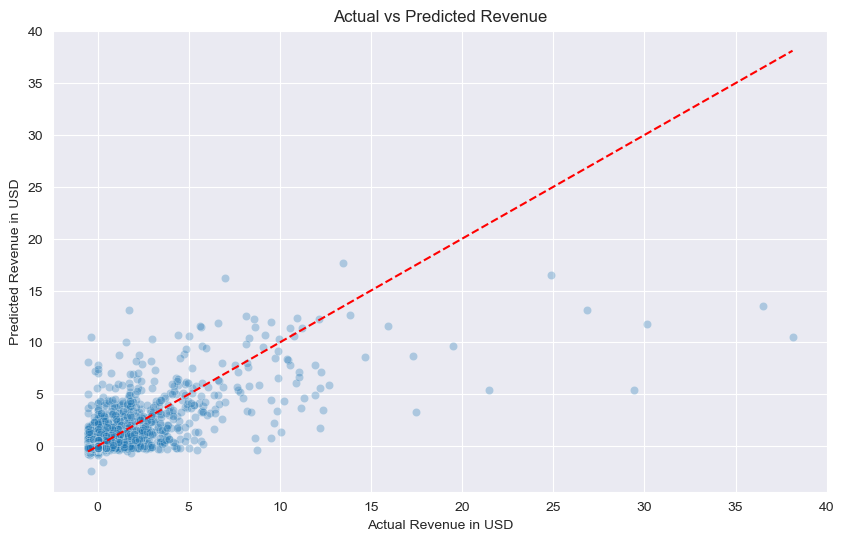

In [203]:
supervised_model.plot_result(y_test, y_pred)

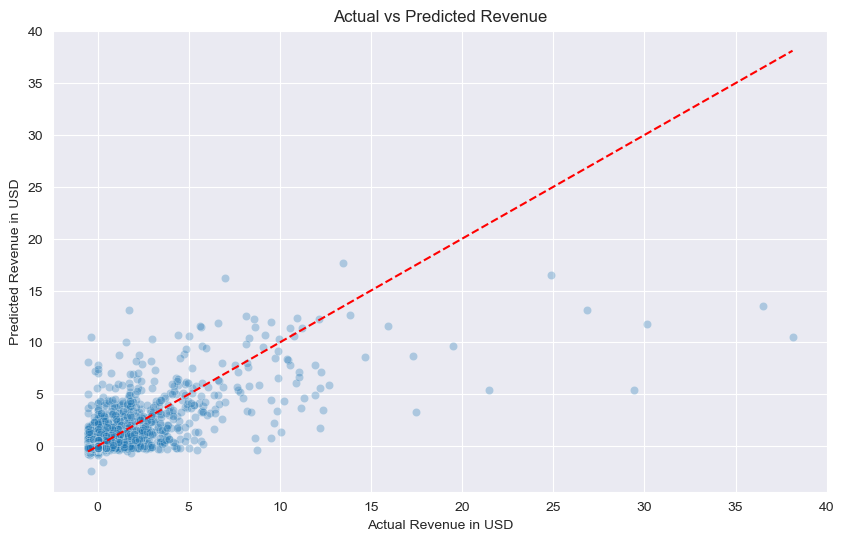

In [204]:
supervised_model.plot_result(y_test_log, y_pred_log)

In [206]:
# supervised_model.plot_result(y_test_trim, y_pred_trim)

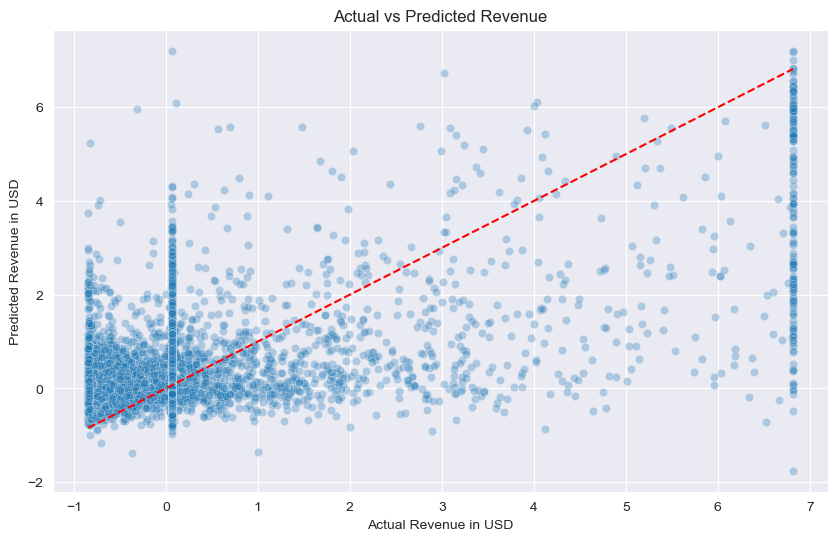

In [207]:
supervised_model.plot_result(y_test_iqr, y_pred_iqr)

### Ridge Regression

In [208]:
y_pred = supervised_model.xgboost_model(X_train, y_train)

Cross-Validation RMSE: [0.72551094 0.58838719 0.67868017 0.7806639  0.76920628]
Mean CV RMSE: 0.7084896938138124
Test RMSE: 0.7066271653769082
0.8993935189036402
0.5131926516631863


In [209]:
y_pred_log = supervised_model.xgboost_model(X_train_log, y_train_log)

Cross-Validation RMSE: [0.72551094 0.58838719 0.67868017 0.7806639  0.76920628]
Mean CV RMSE: 0.7084896938138124
Test RMSE: 0.7066271653769082
0.8993935189036402
0.5131926516631863


In [210]:
y_pred_trim = supervised_model.xgboost_model(X_train_trim, y_train_trim)

Cross-Validation RMSE: [0.65712321 0.68934979 0.77732175 0.81441751 0.67731635]
Mean CV RMSE: 0.7231057225489669
Test RMSE: 0.7174507968726462
0.958727606506259
0.4981652729960768


In [211]:
y_pred_iqr = supervised_model.xgboost_model(X_train_iqr, y_train_iqr)

Cross-Validation RMSE: [0.74024667 0.67350952 0.67220609 0.73966892 0.70527515]
Mean CV RMSE: 0.7061812686601148
Test RMSE: 0.8551520099819138
0.8187512302845278
0.2870433760484492


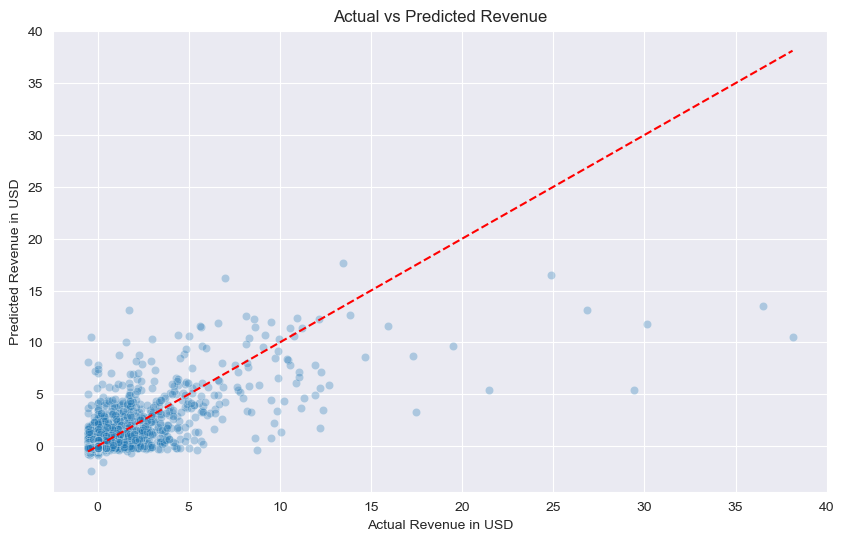

In [212]:
supervised_model.plot_result(y_test, y_pred)

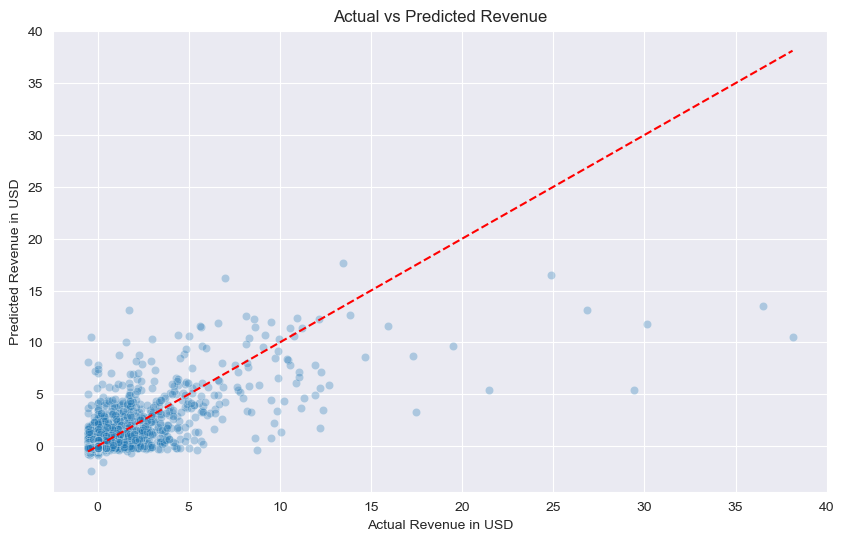

In [213]:
supervised_model.plot_result(y_test_log, y_pred_log)

In [214]:
# supervised_model.plot_result(y_test_trim, y_pred_trim)

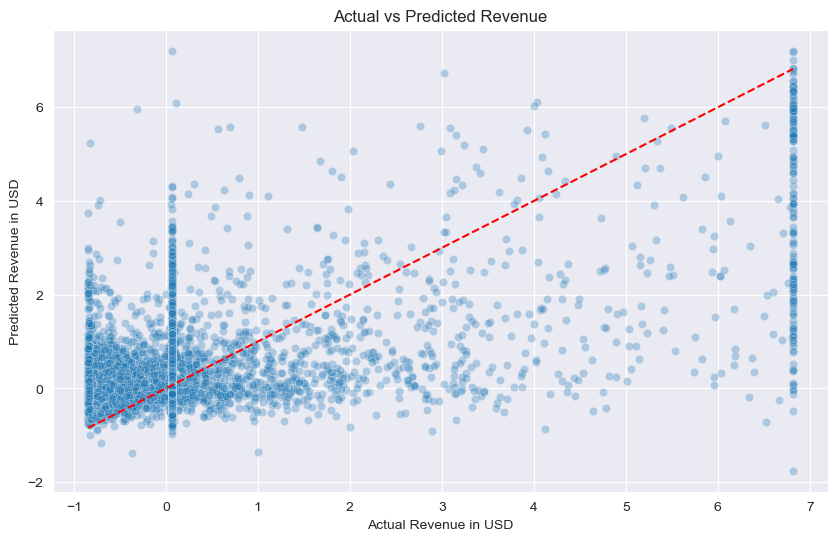

In [215]:
supervised_model.plot_result(y_test_iqr, y_pred_iqr)

8. Results and Visualization (based on regression models):
    - 8.1 Create meaningful visualizations of your findings (e.g., actual vs predicted revenues)
    - 8.2 Interpret and explain results<br /><br />


9. Unsupervised Learning:
    - 9.1 Select and apply two unsupervised learning methods
    - 9.2 Analyze and interpret results
    - 9.3 Compare outcomes of different methods
    - 9.4 Create a feature from this cluster generated and put it into the regression model 
    - 9.5 Analyse the result from the new feature you engineered    <br /><br />


/var/folders/sb/_wglw_tj2s33qkd3sqbydk480000gn/T/ipykernel_3023/1085155253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df.loc[:, 'revenue_in_usd'] = df_not_null.loc[:, 'revenue_in_usd']
/var/folders/sb/_wglw_tj2s33qkd3sqbydk480000gn/T/ipykernel_3023/1085155253.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df.loc[:, 'revenue_in_usd_log'] = df_not_null.loc[:, 'revenue_in_usd_log']


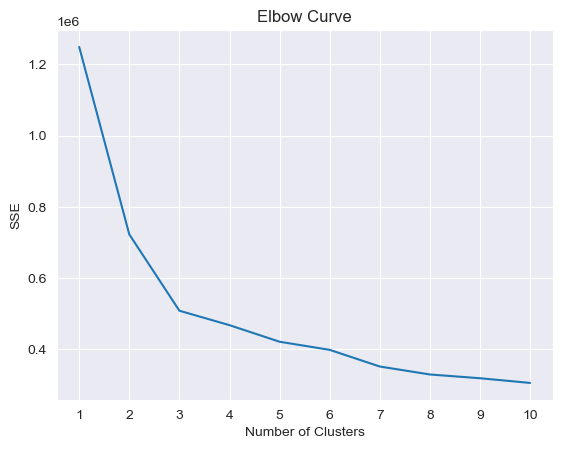

In [217]:
# KMeans Clustering
from sklearn.cluster import KMeans

# standardize the entire data
movie_df = X
movie_df.loc[:, 'revenue_in_usd'] = df_not_null.loc[:, 'revenue_in_usd']
movie_df.loc[:, 'budget_in_usd'] = df_not_null.loc[:, 'budget_in_usd']
movie_df.loc[:, 'revenue_in_usd_log'] = df_not_null.loc[:, 'revenue_in_usd_log']

# determine number of clusters using the elbow method

# initialize kmeans parameters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 42,
    "max_iter": 300
}

range_value = range(1, 11)

# create list to hold SSE values for each k
sse = []
for k in range_value:
    k_means = KMeans(n_clusters=k, **kmeans_kwargs)
    k_means.fit(movie_df)
    sse.append(k_means.inertia_)

# visualize results
plt.plot(range_value, sse)
plt.xticks(range_value)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Curve")
plt.show()

In [227]:
from kneed import KneeLocator

# determine number of clusters
kl = KneeLocator(range_value, sse, curve="convex", direction="decreasing")

# call the function
kl.elbow

3

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


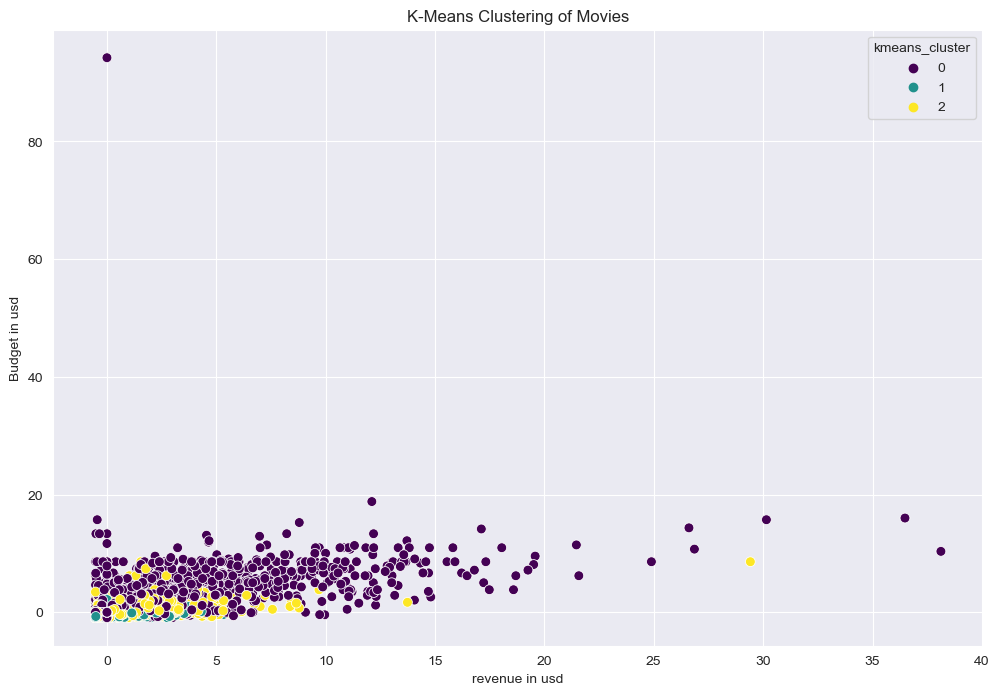

In [228]:
# Example using the optimal K from elbow method (adjust as per your elbow plot)
optimal_k = 3

# Initialize KMeans with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataframe
movie_df.loc[:, 'kmeans_cluster'] = kmeans_clusters

# Example scatter plot of clusters (adjust features as needed)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='revenue_in_usd', y='budget_in_usd', hue='kmeans_cluster', data=movie_df, palette='viridis', s=50)
plt.title('K-Means Clustering of Movies')
plt.xlabel('revenue in usd')
plt.ylabel('Budget in usd')
plt.show()

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


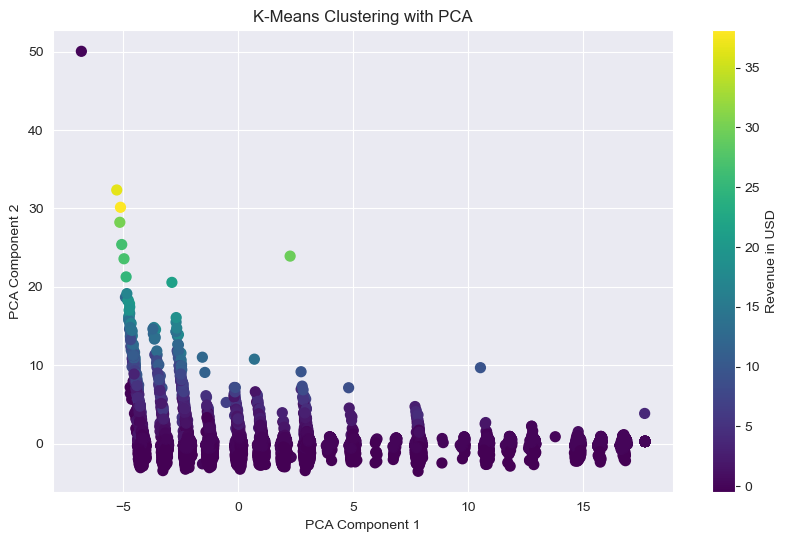

In [222]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA
pca = PCA(n_components=2)  # Using 2 components for visualization
X_pca = pca.fit_transform(movie_df)

# Train K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_pca_kmeans = kmeans.fit_predict(X_pca)

# Plot the clusters with revenue_in_USD as color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.title('K-Means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Revenue in USD')
plt.show()


In [223]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
transformed_x = pca.fit_transform(X)

In [224]:
k_means_pca_df = pd.DataFrame(
    np.hstack((transformed_x, k_means.labels_.reshape(-1, 1))),
    columns=[
        "pca1", "pca2", "pca3", "pca4", "pca5", "pca6",
        "pca7", "pca8", "pca9", "pca10", "clusters"
    ]
)

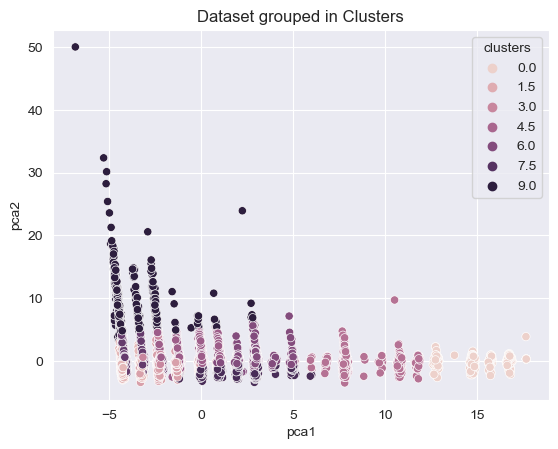

In [226]:
# K Means classes
sns.scatterplot(x="pca1", y="pca2", hue='clusters', data=k_means_pca_df)
plt.plot()
plt.title("Dataset grouped in Clusters")
plt.show()

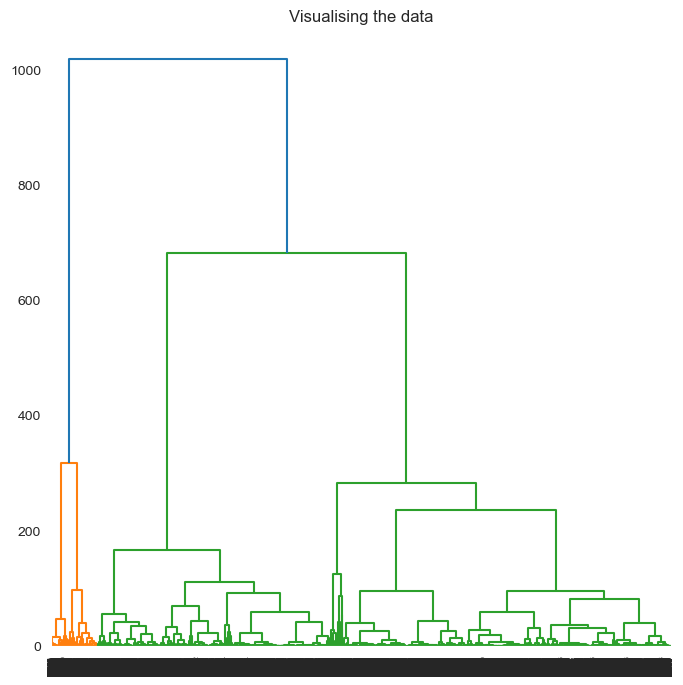

In [232]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc

pca = PCA(n_components=2)
X_principal = pca.fit_transform(movie_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

pca = PCA(n_components=2)
X_principal = pca.fit_transform(movie_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

plt.figure(figsize=(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method='ward')))

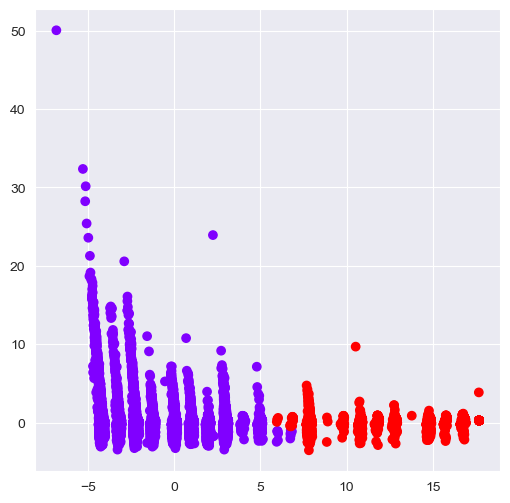

In [233]:
from sklearn.cluster import AgglomerativeClustering

ac2 = AgglomerativeClustering(n_clusters=2)

# Visualizing the clustering 
plt.figure(figsize=(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'],
            c=ac2.fit_predict(X_principal), cmap='rainbow')
plt.show()

Number of clusters: 3
Cluster centers:
Cluster 0: [0.32722469 0.20595918]
Cluster 1: [0.72885631 0.69627424]
Cluster 2: [0.26331356 0.63502106]


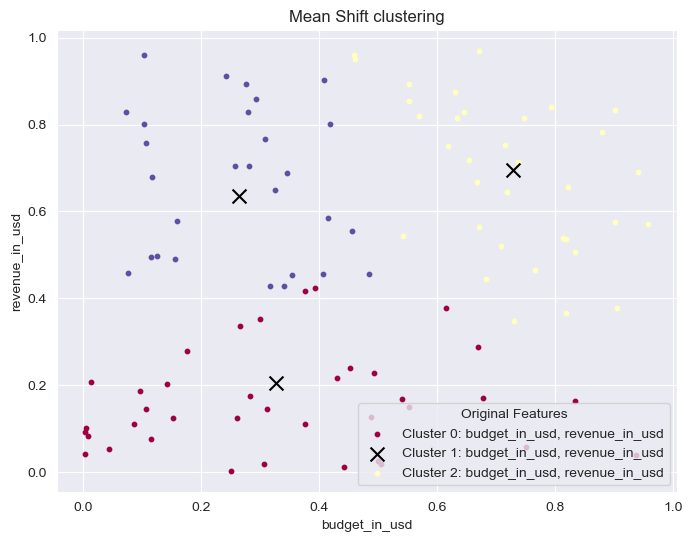

In [236]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth


def plot_mean_shift_clusters(X, feature_names=None):
    # Estimate bandwidth (this can be automatically done using ⁠ estimate_bandwidth() ⁠)
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

    # Fit Mean Shift clustering
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(np.unique(labels))

    # Print analysis
    print(f"Number of clusters: {n_clusters_}")
    print("Cluster centers:")
    for i, center in enumerate(cluster_centers):
        print(f"Cluster {i}: {center}")

    # Plot result
    plt.figure(figsize=(8, 6))
    colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters_))
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        plt.scatter(X[my_members, 0], X[my_members, 1], c=[col], marker='o', s=10, label=f'Cluster {k}')
        plt.scatter(cluster_center[0], cluster_center[1], c='k', marker='x', s=100)

    # Set axes labels with original feature names
    if feature_names:
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
    else:
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.title('Mean Shift clustering')

    # Legend with original feature names
    if feature_names:
        plt.legend(title='Original Features',
                   labels=[f'Cluster {k}: {feature_names[0]}, {feature_names[1]}' for k in range(n_clusters_)])
    else:
        plt.legend(title='Original Features', labels=[f'Cluster {k}: Feature 1, Feature 2' for k in range(n_clusters_)])

    plt.show()


feature_names = ['budget_in_usd', 'revenue_in_usd']

# Plot Mean Shift clusters and analyze
plot_mean_shift_clusters(X, feature_names=feature_names)